In [1]:
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_OF.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
42373,winKen_wave_u_cm_np1_ri_bad_1_flow6.jpg,wave
42374,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42375,winKen_wave_u_cm_np1_ri_bad_1_flow7.jpg,wave
42376,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave
42377,winKen_wave_u_cm_np1_ri_bad_1_flow8.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame_OF/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 42378/42378 [02:59<00:00, 235.74it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(42378, 224, 224, 3)

In [5]:
val = pd.read_csv('../data/val_OF.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
8798,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8799,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8800,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8801,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
8802,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame_OF/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 8803/8803 [01:06<00:00, 131.94it/s]


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(8803, 224, 224, 3)

In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(y_train.shape)
print(y_test.shape)
train.nunique()
val.nunique()

(42378,)
(8803,)


image    8803
class      51
dtype: int64

In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(42378, 51)
(8803, 51)


In [10]:
# creating the base model of pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

In [11]:
print(base_model.output_shape)

(None, None, None, 512)


In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [13]:
base_model.get_config()

{'name': 'vgg16',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'block1_conv1',
   'class_name': 'Conv2D',
   'config': {'name': 'block1_conv1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[['input_1',

In [14]:
base_model.get_weights()

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
          [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
           -9.431

In [15]:
# extracting features for training frames
X_train = base_model.predict(X_train)
X_train.shape

(42378, 7, 7, 512)

In [16]:
# extracting features for validation frames
X_test = base_model.predict(X_test)
X_test.shape

(8803, 7, 7, 512)

In [18]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(42378, 7*7*512)
X_test = X_test.reshape(8803, 7*7*512)

In [19]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [20]:
# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/VGG16_X_train_OF.pkl') 
joblib.dump(X_test, '../Pickle/VGG16_X_test_OF.pkl')

['../Pickle/VGG16_X_test_OF.pkl']

In [21]:
# Load the model from the file 
X_train = joblib.load('../Pickle/VGG16_X_train_OF.pkl') 
X_test = joblib.load('../Pickle/VGG16_X_test_OF.pkl') 

In [22]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42378, 25088)
(8803, 25088)
(42378, 51)
(8803, 51)


In [23]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [24]:
model.output_shape

(None, 51)

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [26]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 25088),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initi

In [27]:
model.get_weights()

[array([[-0.0075254 , -0.00321148,  0.01081377, ...,  0.00287554,
         -0.00831373,  0.0126762 ],
        [ 0.01030092,  0.00431358,  0.01185755, ...,  0.00038179,
         -0.00716632, -0.00581527],
        [-0.00165548, -0.00939845, -0.00297043, ...,  0.0063107 ,
         -0.00473669,  0.01398297],
        ...,
        [-0.0069483 , -0.0064958 , -0.00616747, ...,  0.01491971,
          0.00059161, -0.00582618],
        [-0.00923821, -0.01455695,  0.00955296, ...,  0.00036246,
         -0.00200645, -0.00562109],
        [ 0.00508882, -0.00645195,  0.01153736, ..., -0.01113992,
          0.01012781,  0.00609872]], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([[ 0.05844757, -0.01449157, -0.02006844, ...,  0.06164011,
          0.00741071,  0.03590336],
        [-0.03933544,  0.04002135,  0.00841643, ...,  0.06210579,
         -0.02216966, -0.04429318],
        [ 0.05810714, -0.04575208, -0.01451187, ...,  0.01375607,
         -0.00211401, -0.03382926]

In [28]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightVGG16_OF.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [29]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [30]:
# training the model
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)

Train on 42378 samples, validate on 8803 samples
Epoch 1/100
23552/42378 [===============>..............] - ETA: 8:15 - loss: 3.9490 - accuracy: 0.01 - ETA: 5:04 - loss: 3.9656 - accuracy: 0.01 - ETA: 4:00 - loss: 3.9878 - accuracy: 0.02 - ETA: 3:28 - loss: 3.9970 - accuracy: 0.02 - ETA: 3:08 - loss: 4.0088 - accuracy: 0.02 - ETA: 2:54 - loss: 4.0182 - accuracy: 0.02 - ETA: 2:43 - loss: 4.0157 - accuracy: 0.02 - ETA: 2:35 - loss: 4.0187 - accuracy: 0.02 - ETA: 2:28 - loss: 4.0126 - accuracy: 0.02 - ETA: 2:22 - loss: 4.0029 - accuracy: 0.02 - ETA: 2:18 - loss: 3.9971 - accuracy: 0.02 - ETA: 2:14 - loss: 3.9957 - accuracy: 0.03 - ETA: 2:11 - loss: 3.9924 - accuracy: 0.02 - ETA: 2:08 - loss: 3.9905 - accuracy: 0.03 - ETA: 2:06 - loss: 3.9884 - accuracy: 0.03 - ETA: 2:03 - loss: 3.9865 - accuracy: 0.03 - ETA: 2:01 - loss: 3.9810 - accuracy: 0.03 - ETA: 2:00 - loss: 3.9773 - accuracy: 0.03 - ETA: 1:58 - loss: 3.9750 - accuracy: 0.03 - ETA: 1:56 - loss: 3.9734 - accuracy: 0.03 - ETA: 1:55 - 

23808/42378 [===============>..............] - ETA: 1:39 - loss: 3.6322 - accuracy: 0.07 - ETA: 1:40 - loss: 3.7084 - accuracy: 0.07 - ETA: 1:40 - loss: 3.7348 - accuracy: 0.06 - ETA: 1:39 - loss: 3.7326 - accuracy: 0.06 - ETA: 1:39 - loss: 3.7222 - accuracy: 0.06 - ETA: 1:39 - loss: 3.7288 - accuracy: 0.06 - ETA: 1:38 - loss: 3.7182 - accuracy: 0.06 - ETA: 1:39 - loss: 3.7257 - accuracy: 0.06 - ETA: 1:39 - loss: 3.7272 - accuracy: 0.05 - ETA: 1:39 - loss: 3.7223 - accuracy: 0.06 - ETA: 1:38 - loss: 3.7114 - accuracy: 0.06 - ETA: 1:37 - loss: 3.7090 - accuracy: 0.06 - ETA: 1:37 - loss: 3.7202 - accuracy: 0.06 - ETA: 1:36 - loss: 3.7228 - accuracy: 0.06 - ETA: 1:36 - loss: 3.7210 - accuracy: 0.06 - ETA: 1:36 - loss: 3.7199 - accuracy: 0.06 - ETA: 1:35 - loss: 3.7199 - accuracy: 0.06 - ETA: 1:35 - loss: 3.7243 - accuracy: 0.06 - ETA: 1:35 - loss: 3.7208 - accuracy: 0.06 - ETA: 1:34 - loss: 3.7199 - accuracy: 0.06 - ETA: 1:34 - loss: 3.7208 - accuracy: 0.06 - ETA: 1:34 - loss: 3.7197 - ac

42378/42378 [==============================] - ETA: 45s - loss: 3.6844 - accuracy: 0.069 - ETA: 45s - loss: 3.6847 - accuracy: 0.069 - ETA: 44s - loss: 3.6844 - accuracy: 0.069 - ETA: 44s - loss: 3.6842 - accuracy: 0.069 - ETA: 44s - loss: 3.6839 - accuracy: 0.069 - ETA: 43s - loss: 3.6841 - accuracy: 0.069 - ETA: 43s - loss: 3.6838 - accuracy: 0.068 - ETA: 43s - loss: 3.6838 - accuracy: 0.068 - ETA: 42s - loss: 3.6836 - accuracy: 0.069 - ETA: 42s - loss: 3.6836 - accuracy: 0.068 - ETA: 42s - loss: 3.6841 - accuracy: 0.068 - ETA: 42s - loss: 3.6838 - accuracy: 0.069 - ETA: 41s - loss: 3.6839 - accuracy: 0.068 - ETA: 41s - loss: 3.6840 - accuracy: 0.068 - ETA: 41s - loss: 3.6838 - accuracy: 0.069 - ETA: 40s - loss: 3.6829 - accuracy: 0.069 - ETA: 40s - loss: 3.6829 - accuracy: 0.068 - ETA: 40s - loss: 3.6828 - accuracy: 0.068 - ETA: 39s - loss: 3.6827 - accuracy: 0.068 - ETA: 39s - loss: 3.6821 - accuracy: 0.068 - ETA: 39s - loss: 3.6820 - accuracy: 0.069 - ETA: 39s - loss: 3.6814 - acc

23808/42378 [===============>..............] - ETA: 1:36 - loss: 3.5368 - accuracy: 0.07 - ETA: 1:36 - loss: 3.5217 - accuracy: 0.07 - ETA: 1:37 - loss: 3.5469 - accuracy: 0.07 - ETA: 1:37 - loss: 3.5323 - accuracy: 0.08 - ETA: 1:37 - loss: 3.5361 - accuracy: 0.07 - ETA: 1:36 - loss: 3.5511 - accuracy: 0.08 - ETA: 1:36 - loss: 3.5532 - accuracy: 0.08 - ETA: 1:36 - loss: 3.5494 - accuracy: 0.08 - ETA: 1:36 - loss: 3.5726 - accuracy: 0.08 - ETA: 1:36 - loss: 3.5749 - accuracy: 0.07 - ETA: 1:35 - loss: 3.5749 - accuracy: 0.08 - ETA: 1:35 - loss: 3.5734 - accuracy: 0.08 - ETA: 1:35 - loss: 3.5792 - accuracy: 0.07 - ETA: 1:35 - loss: 3.5836 - accuracy: 0.07 - ETA: 1:34 - loss: 3.5853 - accuracy: 0.07 - ETA: 1:34 - loss: 3.5875 - accuracy: 0.08 - ETA: 1:34 - loss: 3.5903 - accuracy: 0.07 - ETA: 1:34 - loss: 3.5869 - accuracy: 0.07 - ETA: 1:33 - loss: 3.5848 - accuracy: 0.07 - ETA: 1:33 - loss: 3.5854 - accuracy: 0.07 - ETA: 1:33 - loss: 3.5861 - accuracy: 0.07 - ETA: 1:33 - loss: 3.5877 - ac

42378/42378 [==============================] - ETA: 46s - loss: 3.5157 - accuracy: 0.093 - ETA: 46s - loss: 3.5157 - accuracy: 0.093 - ETA: 46s - loss: 3.5160 - accuracy: 0.093 - ETA: 45s - loss: 3.5162 - accuracy: 0.093 - ETA: 45s - loss: 3.5157 - accuracy: 0.093 - ETA: 45s - loss: 3.5159 - accuracy: 0.093 - ETA: 44s - loss: 3.5160 - accuracy: 0.093 - ETA: 44s - loss: 3.5161 - accuracy: 0.093 - ETA: 44s - loss: 3.5158 - accuracy: 0.093 - ETA: 43s - loss: 3.5154 - accuracy: 0.093 - ETA: 43s - loss: 3.5154 - accuracy: 0.093 - ETA: 43s - loss: 3.5159 - accuracy: 0.093 - ETA: 42s - loss: 3.5157 - accuracy: 0.093 - ETA: 42s - loss: 3.5155 - accuracy: 0.093 - ETA: 42s - loss: 3.5149 - accuracy: 0.093 - ETA: 41s - loss: 3.5146 - accuracy: 0.093 - ETA: 41s - loss: 3.5150 - accuracy: 0.093 - ETA: 41s - loss: 3.5147 - accuracy: 0.093 - ETA: 40s - loss: 3.5144 - accuracy: 0.093 - ETA: 40s - loss: 3.5141 - accuracy: 0.093 - ETA: 40s - loss: 3.5142 - accuracy: 0.093 - ETA: 39s - loss: 3.5149 - acc

23808/42378 [===============>..............] - ETA: 1:47 - loss: 3.3180 - accuracy: 0.07 - ETA: 1:46 - loss: 3.3914 - accuracy: 0.08 - ETA: 1:45 - loss: 3.3961 - accuracy: 0.09 - ETA: 1:44 - loss: 3.3609 - accuracy: 0.10 - ETA: 1:43 - loss: 3.3902 - accuracy: 0.10 - ETA: 1:43 - loss: 3.4026 - accuracy: 0.10 - ETA: 1:42 - loss: 3.3992 - accuracy: 0.11 - ETA: 1:43 - loss: 3.3865 - accuracy: 0.11 - ETA: 1:43 - loss: 3.3694 - accuracy: 0.11 - ETA: 1:42 - loss: 3.3797 - accuracy: 0.11 - ETA: 1:42 - loss: 3.3751 - accuracy: 0.11 - ETA: 1:42 - loss: 3.3830 - accuracy: 0.11 - ETA: 1:41 - loss: 3.3836 - accuracy: 0.11 - ETA: 1:40 - loss: 3.3826 - accuracy: 0.11 - ETA: 1:40 - loss: 3.3875 - accuracy: 0.11 - ETA: 1:39 - loss: 3.3900 - accuracy: 0.11 - ETA: 1:39 - loss: 3.3890 - accuracy: 0.11 - ETA: 1:38 - loss: 3.3883 - accuracy: 0.11 - ETA: 1:38 - loss: 3.3872 - accuracy: 0.11 - ETA: 1:37 - loss: 3.3962 - accuracy: 0.10 - ETA: 1:37 - loss: 3.3919 - accuracy: 0.11 - ETA: 1:37 - loss: 3.3878 - ac

42378/42378 [==============================] - ETA: 48s - loss: 3.3690 - accuracy: 0.115 - ETA: 47s - loss: 3.3680 - accuracy: 0.115 - ETA: 47s - loss: 3.3665 - accuracy: 0.115 - ETA: 47s - loss: 3.3669 - accuracy: 0.115 - ETA: 46s - loss: 3.3665 - accuracy: 0.115 - ETA: 46s - loss: 3.3669 - accuracy: 0.115 - ETA: 46s - loss: 3.3662 - accuracy: 0.115 - ETA: 45s - loss: 3.3662 - accuracy: 0.115 - ETA: 45s - loss: 3.3673 - accuracy: 0.115 - ETA: 45s - loss: 3.3678 - accuracy: 0.115 - ETA: 44s - loss: 3.3681 - accuracy: 0.115 - ETA: 44s - loss: 3.3681 - accuracy: 0.115 - ETA: 44s - loss: 3.3687 - accuracy: 0.115 - ETA: 43s - loss: 3.3692 - accuracy: 0.114 - ETA: 43s - loss: 3.3692 - accuracy: 0.114 - ETA: 42s - loss: 3.3689 - accuracy: 0.114 - ETA: 42s - loss: 3.3686 - accuracy: 0.114 - ETA: 42s - loss: 3.3693 - accuracy: 0.114 - ETA: 41s - loss: 3.3703 - accuracy: 0.114 - ETA: 41s - loss: 3.3704 - accuracy: 0.114 - ETA: 41s - loss: 3.3703 - accuracy: 0.114 - ETA: 40s - loss: 3.3707 - acc

23808/42378 [===============>..............] - ETA: 1:51 - loss: 3.9428 - accuracy: 0.08 - ETA: 1:46 - loss: 3.6510 - accuracy: 0.08 - ETA: 1:43 - loss: 3.5838 - accuracy: 0.09 - ETA: 1:42 - loss: 3.5397 - accuracy: 0.09 - ETA: 1:41 - loss: 3.5359 - accuracy: 0.09 - ETA: 1:40 - loss: 3.5359 - accuracy: 0.09 - ETA: 1:40 - loss: 3.5114 - accuracy: 0.10 - ETA: 1:39 - loss: 3.4907 - accuracy: 0.10 - ETA: 1:38 - loss: 3.5015 - accuracy: 0.10 - ETA: 1:38 - loss: 3.5036 - accuracy: 0.10 - ETA: 1:37 - loss: 3.5091 - accuracy: 0.09 - ETA: 1:36 - loss: 3.5046 - accuracy: 0.09 - ETA: 1:36 - loss: 3.4998 - accuracy: 0.09 - ETA: 1:35 - loss: 3.4848 - accuracy: 0.09 - ETA: 1:35 - loss: 3.4855 - accuracy: 0.09 - ETA: 1:34 - loss: 3.4839 - accuracy: 0.09 - ETA: 1:34 - loss: 3.4718 - accuracy: 0.10 - ETA: 1:34 - loss: 3.4692 - accuracy: 0.10 - ETA: 1:34 - loss: 3.4683 - accuracy: 0.10 - ETA: 1:34 - loss: 3.4641 - accuracy: 0.10 - ETA: 1:34 - loss: 3.4713 - accuracy: 0.10 - ETA: 1:34 - loss: 3.4721 - ac

42378/42378 [==============================] - ETA: 43s - loss: 3.3258 - accuracy: 0.126 - ETA: 43s - loss: 3.3252 - accuracy: 0.126 - ETA: 43s - loss: 3.3246 - accuracy: 0.126 - ETA: 42s - loss: 3.3243 - accuracy: 0.127 - ETA: 42s - loss: 3.3249 - accuracy: 0.126 - ETA: 42s - loss: 3.3240 - accuracy: 0.126 - ETA: 41s - loss: 3.3233 - accuracy: 0.126 - ETA: 41s - loss: 3.3236 - accuracy: 0.126 - ETA: 41s - loss: 3.3240 - accuracy: 0.126 - ETA: 41s - loss: 3.3240 - accuracy: 0.126 - ETA: 40s - loss: 3.3239 - accuracy: 0.126 - ETA: 40s - loss: 3.3243 - accuracy: 0.126 - ETA: 40s - loss: 3.3242 - accuracy: 0.126 - ETA: 39s - loss: 3.3238 - accuracy: 0.126 - ETA: 39s - loss: 3.3240 - accuracy: 0.126 - ETA: 39s - loss: 3.3231 - accuracy: 0.126 - ETA: 38s - loss: 3.3233 - accuracy: 0.126 - ETA: 38s - loss: 3.3224 - accuracy: 0.127 - ETA: 38s - loss: 3.3222 - accuracy: 0.127 - ETA: 38s - loss: 3.3229 - accuracy: 0.126 - ETA: 37s - loss: 3.3226 - accuracy: 0.127 - ETA: 37s - loss: 3.3225 - acc

23808/42378 [===============>..............] - ETA: 1:46 - loss: 3.5103 - accuracy: 0.12 - ETA: 1:45 - loss: 3.3495 - accuracy: 0.12 - ETA: 1:43 - loss: 3.3323 - accuracy: 0.12 - ETA: 1:41 - loss: 3.3205 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3205 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3188 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3196 - accuracy: 0.12 - ETA: 1:40 - loss: 3.3082 - accuracy: 0.12 - ETA: 1:40 - loss: 3.2900 - accuracy: 0.13 - ETA: 1:39 - loss: 3.3025 - accuracy: 0.12 - ETA: 1:39 - loss: 3.3070 - accuracy: 0.13 - ETA: 1:38 - loss: 3.3195 - accuracy: 0.12 - ETA: 1:38 - loss: 3.3267 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3321 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3338 - accuracy: 0.13 - ETA: 1:37 - loss: 3.3382 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3440 - accuracy: 0.12 - ETA: 1:37 - loss: 3.3388 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3387 - accuracy: 0.12 - ETA: 1:36 - loss: 3.3444 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3353 - accuracy: 0.12 - ETA: 1:35 - loss: 3.3412 - ac

42378/42378 [==============================] - ETA: 45s - loss: 3.2388 - accuracy: 0.143 - ETA: 44s - loss: 3.2384 - accuracy: 0.143 - ETA: 44s - loss: 3.2383 - accuracy: 0.143 - ETA: 44s - loss: 3.2380 - accuracy: 0.143 - ETA: 43s - loss: 3.2381 - accuracy: 0.143 - ETA: 43s - loss: 3.2379 - accuracy: 0.143 - ETA: 43s - loss: 3.2372 - accuracy: 0.143 - ETA: 42s - loss: 3.2368 - accuracy: 0.143 - ETA: 42s - loss: 3.2367 - accuracy: 0.143 - ETA: 42s - loss: 3.2364 - accuracy: 0.143 - ETA: 41s - loss: 3.2360 - accuracy: 0.143 - ETA: 41s - loss: 3.2347 - accuracy: 0.144 - ETA: 41s - loss: 3.2354 - accuracy: 0.143 - ETA: 40s - loss: 3.2346 - accuracy: 0.143 - ETA: 40s - loss: 3.2340 - accuracy: 0.143 - ETA: 40s - loss: 3.2335 - accuracy: 0.144 - ETA: 40s - loss: 3.2332 - accuracy: 0.144 - ETA: 39s - loss: 3.2334 - accuracy: 0.144 - ETA: 39s - loss: 3.2337 - accuracy: 0.144 - ETA: 39s - loss: 3.2339 - accuracy: 0.144 - ETA: 38s - loss: 3.2334 - accuracy: 0.144 - ETA: 38s - loss: 3.2341 - acc

23808/42378 [===============>..............] - ETA: 2:46 - loss: 3.2038 - accuracy: 0.21 - ETA: 2:41 - loss: 3.1948 - accuracy: 0.18 - ETA: 2:39 - loss: 3.1774 - accuracy: 0.17 - ETA: 2:40 - loss: 3.1776 - accuracy: 0.15 - ETA: 2:41 - loss: 3.1624 - accuracy: 0.15 - ETA: 2:41 - loss: 3.1315 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1679 - accuracy: 0.15 - ETA: 2:39 - loss: 3.1870 - accuracy: 0.14 - ETA: 2:38 - loss: 3.1873 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1655 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1779 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1775 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1799 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1718 - accuracy: 0.16 - ETA: 2:35 - loss: 3.1719 - accuracy: 0.15 - ETA: 2:34 - loss: 3.1615 - accuracy: 0.16 - ETA: 2:34 - loss: 3.1715 - accuracy: 0.15 - ETA: 2:33 - loss: 3.1628 - accuracy: 0.15 - ETA: 2:33 - loss: 3.1652 - accuracy: 0.15 - ETA: 2:33 - loss: 3.1604 - accuracy: 0.15 - ETA: 2:33 - loss: 3.1612 - accuracy: 0.15 - ETA: 2:32 - loss: 3.1672 - ac

42378/42378 [==============================] - ETA: 1:11 - loss: 3.1874 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1881 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1881 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1883 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1888 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1878 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1872 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1878 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1878 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1886 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1879 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1878 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1880 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1886 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1888 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1887 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1894 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1894 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1892 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1890 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1888 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1888 - ac

23808/42378 [===============>..............] - ETA: 2:47 - loss: 3.2698 - accuracy: 0.10 - ETA: 2:46 - loss: 3.1377 - accuracy: 0.16 - ETA: 2:45 - loss: 3.1354 - accuracy: 0.16 - ETA: 2:42 - loss: 3.1318 - accuracy: 0.16 - ETA: 2:40 - loss: 3.1160 - accuracy: 0.17 - ETA: 2:41 - loss: 3.1447 - accuracy: 0.16 - ETA: 2:38 - loss: 3.1410 - accuracy: 0.16 - ETA: 2:38 - loss: 3.1535 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1561 - accuracy: 0.16 - ETA: 2:39 - loss: 3.1600 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1383 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1386 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1462 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1406 - accuracy: 0.16 - ETA: 2:36 - loss: 3.1534 - accuracy: 0.15 - ETA: 2:35 - loss: 3.1500 - accuracy: 0.16 - ETA: 2:33 - loss: 3.1389 - accuracy: 0.16 - ETA: 2:33 - loss: 3.1384 - accuracy: 0.16 - ETA: 2:32 - loss: 3.1440 - accuracy: 0.15 - ETA: 2:32 - loss: 3.1439 - accuracy: 0.15 - ETA: 2:32 - loss: 3.1392 - accuracy: 0.15 - ETA: 2:31 - loss: 3.1316 - ac

42378/42378 [==============================] - ETA: 1:13 - loss: 3.2329 - accuracy: 0.14 - ETA: 1:12 - loss: 3.2335 - accuracy: 0.14 - ETA: 1:12 - loss: 3.2334 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2324 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2319 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2323 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2322 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2316 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2309 - accuracy: 0.14 - ETA: 1:08 - loss: 3.2300 - accuracy: 0.14 - ETA: 1:08 - loss: 3.2304 - accuracy: 0.14 - ETA: 1:07 - loss: 3.2303 - accuracy: 0.14 - ETA: 1:07 - loss: 3.2304 - accuracy: 0.14 - ETA: 1:06 - loss: 3.2297 - accuracy: 0.14 - ETA: 1:05 - loss: 3.2289 - accuracy: 0.14 - ETA: 1:05 - loss: 3.2295 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2294 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2295 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2288 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2288 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2279 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2290 - ac

23808/42378 [===============>..............] - ETA: 2:38 - loss: 3.3576 - accuracy: 0.16 - ETA: 2:43 - loss: 3.2606 - accuracy: 0.16 - ETA: 2:45 - loss: 3.2572 - accuracy: 0.16 - ETA: 2:44 - loss: 3.2158 - accuracy: 0.16 - ETA: 2:44 - loss: 3.2415 - accuracy: 0.16 - ETA: 2:44 - loss: 3.2321 - accuracy: 0.16 - ETA: 2:45 - loss: 3.2361 - accuracy: 0.15 - ETA: 2:44 - loss: 3.2134 - accuracy: 0.16 - ETA: 2:44 - loss: 3.2249 - accuracy: 0.16 - ETA: 2:45 - loss: 3.2305 - accuracy: 0.15 - ETA: 2:45 - loss: 3.2229 - accuracy: 0.15 - ETA: 2:44 - loss: 3.2111 - accuracy: 0.15 - ETA: 2:43 - loss: 3.2119 - accuracy: 0.15 - ETA: 2:42 - loss: 3.2112 - accuracy: 0.15 - ETA: 2:40 - loss: 3.2087 - accuracy: 0.15 - ETA: 2:40 - loss: 3.2107 - accuracy: 0.15 - ETA: 2:40 - loss: 3.2213 - accuracy: 0.15 - ETA: 2:40 - loss: 3.2292 - accuracy: 0.15 - ETA: 2:39 - loss: 3.2233 - accuracy: 0.15 - ETA: 2:39 - loss: 3.2224 - accuracy: 0.14 - ETA: 2:38 - loss: 3.2288 - accuracy: 0.14 - ETA: 2:38 - loss: 3.2256 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1810 - accuracy: 0.15 - ETA: 1:12 - loss: 3.1811 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1812 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1819 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1815 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1815 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1820 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1824 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1827 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1832 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1837 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1832 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1823 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1826 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1825 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1831 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1834 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1832 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1842 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1845 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1843 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1836 - ac

23808/42378 [===============>..............] - ETA: 2:21 - loss: 3.2046 - accuracy: 0.16 - ETA: 2:35 - loss: 3.2661 - accuracy: 0.13 - ETA: 2:40 - loss: 3.3428 - accuracy: 0.11 - ETA: 2:39 - loss: 3.3228 - accuracy: 0.11 - ETA: 2:40 - loss: 3.3352 - accuracy: 0.11 - ETA: 2:40 - loss: 3.3234 - accuracy: 0.11 - ETA: 2:39 - loss: 3.3495 - accuracy: 0.11 - ETA: 2:38 - loss: 3.3239 - accuracy: 0.12 - ETA: 2:36 - loss: 3.3149 - accuracy: 0.12 - ETA: 2:35 - loss: 3.3112 - accuracy: 0.12 - ETA: 2:33 - loss: 3.3133 - accuracy: 0.12 - ETA: 2:32 - loss: 3.3095 - accuracy: 0.13 - ETA: 2:30 - loss: 3.2871 - accuracy: 0.13 - ETA: 2:31 - loss: 3.2855 - accuracy: 0.13 - ETA: 2:31 - loss: 3.2813 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2854 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2912 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2846 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2834 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2765 - accuracy: 0.13 - ETA: 2:31 - loss: 3.2727 - accuracy: 0.13 - ETA: 2:30 - loss: 3.2818 - ac

42378/42378 [==============================] - ETA: 1:11 - loss: 3.2763 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2756 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2750 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2745 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2743 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2740 - accuracy: 0.14 - ETA: 1:08 - loss: 3.2735 - accuracy: 0.14 - ETA: 1:08 - loss: 3.2745 - accuracy: 0.14 - ETA: 1:07 - loss: 3.2745 - accuracy: 0.14 - ETA: 1:07 - loss: 3.2750 - accuracy: 0.14 - ETA: 1:07 - loss: 3.2752 - accuracy: 0.14 - ETA: 1:06 - loss: 3.2757 - accuracy: 0.14 - ETA: 1:06 - loss: 3.2764 - accuracy: 0.14 - ETA: 1:05 - loss: 3.2767 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2759 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2758 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2756 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2759 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2752 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2746 - accuracy: 0.14 - ETA: 1:01 - loss: 3.2749 - accuracy: 0.14 - ETA: 1:01 - loss: 3.2753 - ac

23808/42378 [===============>..............] - ETA: 2:32 - loss: 3.4758 - accuracy: 0.10 - ETA: 2:37 - loss: 3.4565 - accuracy: 0.10 - ETA: 2:44 - loss: 3.4480 - accuracy: 0.10 - ETA: 2:43 - loss: 3.4050 - accuracy: 0.11 - ETA: 2:44 - loss: 3.3330 - accuracy: 0.11 - ETA: 2:42 - loss: 3.3340 - accuracy: 0.11 - ETA: 2:42 - loss: 3.3445 - accuracy: 0.12 - ETA: 2:42 - loss: 3.3420 - accuracy: 0.12 - ETA: 2:42 - loss: 3.3303 - accuracy: 0.12 - ETA: 2:41 - loss: 3.3259 - accuracy: 0.12 - ETA: 2:39 - loss: 3.3324 - accuracy: 0.13 - ETA: 2:38 - loss: 3.3402 - accuracy: 0.12 - ETA: 2:39 - loss: 3.3374 - accuracy: 0.12 - ETA: 2:38 - loss: 3.3375 - accuracy: 0.12 - ETA: 2:39 - loss: 3.3278 - accuracy: 0.12 - ETA: 2:38 - loss: 3.3195 - accuracy: 0.12 - ETA: 2:37 - loss: 3.3157 - accuracy: 0.13 - ETA: 2:36 - loss: 3.3156 - accuracy: 0.13 - ETA: 2:36 - loss: 3.3121 - accuracy: 0.13 - ETA: 2:36 - loss: 3.3121 - accuracy: 0.13 - ETA: 2:35 - loss: 3.3095 - accuracy: 0.13 - ETA: 2:35 - loss: 3.3068 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.2482 - accuracy: 0.14 - ETA: 1:12 - loss: 3.2473 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2466 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2451 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2450 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2451 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2438 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2424 - accuracy: 0.14 - ETA: 1:08 - loss: 3.2430 - accuracy: 0.14 - ETA: 1:08 - loss: 3.2432 - accuracy: 0.14 - ETA: 1:07 - loss: 3.2427 - accuracy: 0.14 - ETA: 1:07 - loss: 3.2425 - accuracy: 0.14 - ETA: 1:06 - loss: 3.2420 - accuracy: 0.14 - ETA: 1:06 - loss: 3.2417 - accuracy: 0.14 - ETA: 1:05 - loss: 3.2415 - accuracy: 0.14 - ETA: 1:05 - loss: 3.2409 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2401 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2401 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2397 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2395 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2395 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2393 - ac

23808/42378 [===============>..............] - ETA: 2:43 - loss: 3.0806 - accuracy: 0.17 - ETA: 2:47 - loss: 3.0662 - accuracy: 0.19 - ETA: 2:49 - loss: 3.1124 - accuracy: 0.17 - ETA: 2:50 - loss: 3.1202 - accuracy: 0.18 - ETA: 2:46 - loss: 3.1555 - accuracy: 0.18 - ETA: 2:43 - loss: 3.1790 - accuracy: 0.17 - ETA: 2:41 - loss: 3.1588 - accuracy: 0.17 - ETA: 2:38 - loss: 3.1622 - accuracy: 0.17 - ETA: 2:37 - loss: 3.1614 - accuracy: 0.17 - ETA: 2:36 - loss: 3.1549 - accuracy: 0.17 - ETA: 2:36 - loss: 3.1586 - accuracy: 0.17 - ETA: 2:36 - loss: 3.1498 - accuracy: 0.17 - ETA: 2:36 - loss: 3.1436 - accuracy: 0.17 - ETA: 2:36 - loss: 3.1499 - accuracy: 0.16 - ETA: 2:36 - loss: 3.1525 - accuracy: 0.16 - ETA: 2:36 - loss: 3.1546 - accuracy: 0.16 - ETA: 2:36 - loss: 3.1576 - accuracy: 0.16 - ETA: 2:35 - loss: 3.1570 - accuracy: 0.16 - ETA: 2:34 - loss: 3.1553 - accuracy: 0.16 - ETA: 2:34 - loss: 3.1535 - accuracy: 0.16 - ETA: 2:35 - loss: 3.1527 - accuracy: 0.16 - ETA: 2:34 - loss: 3.1471 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1379 - accuracy: 0.16 - ETA: 1:11 - loss: 3.1387 - accuracy: 0.16 - ETA: 1:11 - loss: 3.1397 - accuracy: 0.16 - ETA: 1:10 - loss: 3.1398 - accuracy: 0.16 - ETA: 1:10 - loss: 3.1394 - accuracy: 0.16 - ETA: 1:09 - loss: 3.1403 - accuracy: 0.16 - ETA: 1:09 - loss: 3.1410 - accuracy: 0.16 - ETA: 1:08 - loss: 3.1398 - accuracy: 0.16 - ETA: 1:08 - loss: 3.1402 - accuracy: 0.16 - ETA: 1:07 - loss: 3.1406 - accuracy: 0.16 - ETA: 1:07 - loss: 3.1406 - accuracy: 0.16 - ETA: 1:06 - loss: 3.1404 - accuracy: 0.16 - ETA: 1:06 - loss: 3.1404 - accuracy: 0.16 - ETA: 1:05 - loss: 3.1414 - accuracy: 0.16 - ETA: 1:05 - loss: 3.1411 - accuracy: 0.16 - ETA: 1:04 - loss: 3.1402 - accuracy: 0.16 - ETA: 1:04 - loss: 3.1398 - accuracy: 0.16 - ETA: 1:03 - loss: 3.1388 - accuracy: 0.16 - ETA: 1:03 - loss: 3.1390 - accuracy: 0.16 - ETA: 1:02 - loss: 3.1399 - accuracy: 0.16 - ETA: 1:02 - loss: 3.1396 - accuracy: 0.16 - ETA: 1:01 - loss: 3.1392 - ac

23808/42378 [===============>..............] - ETA: 2:48 - loss: 3.1291 - accuracy: 0.15 - ETA: 2:52 - loss: 3.0264 - accuracy: 0.18 - ETA: 2:51 - loss: 3.0253 - accuracy: 0.15 - ETA: 2:49 - loss: 2.9904 - accuracy: 0.15 - ETA: 2:48 - loss: 2.9781 - accuracy: 0.17 - ETA: 2:48 - loss: 2.9982 - accuracy: 0.17 - ETA: 2:49 - loss: 3.0207 - accuracy: 0.16 - ETA: 2:46 - loss: 3.0285 - accuracy: 0.15 - ETA: 2:46 - loss: 3.0310 - accuracy: 0.16 - ETA: 2:45 - loss: 3.0428 - accuracy: 0.15 - ETA: 2:44 - loss: 3.0533 - accuracy: 0.15 - ETA: 2:44 - loss: 3.0515 - accuracy: 0.16 - ETA: 2:43 - loss: 3.0491 - accuracy: 0.16 - ETA: 2:43 - loss: 3.0422 - accuracy: 0.16 - ETA: 2:42 - loss: 3.0291 - accuracy: 0.17 - ETA: 2:41 - loss: 3.0352 - accuracy: 0.16 - ETA: 2:40 - loss: 3.0334 - accuracy: 0.16 - ETA: 2:39 - loss: 3.0298 - accuracy: 0.16 - ETA: 2:39 - loss: 3.0360 - accuracy: 0.16 - ETA: 2:38 - loss: 3.0257 - accuracy: 0.16 - ETA: 2:37 - loss: 3.0324 - accuracy: 0.16 - ETA: 2:36 - loss: 3.0339 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.0586 - accuracy: 0.17 - ETA: 1:12 - loss: 3.0582 - accuracy: 0.17 - ETA: 1:11 - loss: 3.0578 - accuracy: 0.17 - ETA: 1:11 - loss: 3.0579 - accuracy: 0.17 - ETA: 1:10 - loss: 3.0583 - accuracy: 0.17 - ETA: 1:10 - loss: 3.0579 - accuracy: 0.17 - ETA: 1:09 - loss: 3.0583 - accuracy: 0.17 - ETA: 1:09 - loss: 3.0575 - accuracy: 0.17 - ETA: 1:08 - loss: 3.0571 - accuracy: 0.17 - ETA: 1:08 - loss: 3.0578 - accuracy: 0.17 - ETA: 1:07 - loss: 3.0573 - accuracy: 0.17 - ETA: 1:07 - loss: 3.0562 - accuracy: 0.17 - ETA: 1:06 - loss: 3.0563 - accuracy: 0.17 - ETA: 1:05 - loss: 3.0563 - accuracy: 0.17 - ETA: 1:05 - loss: 3.0563 - accuracy: 0.17 - ETA: 1:04 - loss: 3.0554 - accuracy: 0.17 - ETA: 1:04 - loss: 3.0550 - accuracy: 0.17 - ETA: 1:03 - loss: 3.0541 - accuracy: 0.17 - ETA: 1:03 - loss: 3.0526 - accuracy: 0.17 - ETA: 1:02 - loss: 3.0533 - accuracy: 0.17 - ETA: 1:02 - loss: 3.0537 - accuracy: 0.17 - ETA: 1:01 - loss: 3.0531 - ac

23808/42378 [===============>..............] - ETA: 2:32 - loss: 2.9692 - accuracy: 0.19 - ETA: 2:37 - loss: 3.0212 - accuracy: 0.19 - ETA: 2:38 - loss: 2.9585 - accuracy: 0.20 - ETA: 2:42 - loss: 2.9789 - accuracy: 0.19 - ETA: 2:41 - loss: 3.0070 - accuracy: 0.18 - ETA: 2:40 - loss: 3.0253 - accuracy: 0.18 - ETA: 2:38 - loss: 3.0209 - accuracy: 0.17 - ETA: 2:36 - loss: 3.0303 - accuracy: 0.17 - ETA: 2:35 - loss: 3.0242 - accuracy: 0.17 - ETA: 2:34 - loss: 3.0386 - accuracy: 0.17 - ETA: 2:34 - loss: 3.0514 - accuracy: 0.17 - ETA: 2:33 - loss: 3.0619 - accuracy: 0.17 - ETA: 2:33 - loss: 3.0809 - accuracy: 0.17 - ETA: 2:32 - loss: 3.1007 - accuracy: 0.16 - ETA: 2:33 - loss: 3.1006 - accuracy: 0.16 - ETA: 2:32 - loss: 3.1081 - accuracy: 0.16 - ETA: 2:32 - loss: 3.0967 - accuracy: 0.16 - ETA: 2:32 - loss: 3.1076 - accuracy: 0.16 - ETA: 2:32 - loss: 3.1092 - accuracy: 0.16 - ETA: 2:31 - loss: 3.0957 - accuracy: 0.16 - ETA: 2:30 - loss: 3.0916 - accuracy: 0.16 - ETA: 2:30 - loss: 3.0872 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 2.9723 - accuracy: 0.19 - ETA: 1:11 - loss: 2.9723 - accuracy: 0.19 - ETA: 1:11 - loss: 2.9737 - accuracy: 0.19 - ETA: 1:10 - loss: 2.9730 - accuracy: 0.19 - ETA: 1:10 - loss: 2.9726 - accuracy: 0.19 - ETA: 1:09 - loss: 2.9722 - accuracy: 0.19 - ETA: 1:09 - loss: 2.9728 - accuracy: 0.19 - ETA: 1:08 - loss: 2.9729 - accuracy: 0.19 - ETA: 1:08 - loss: 2.9726 - accuracy: 0.19 - ETA: 1:07 - loss: 2.9720 - accuracy: 0.19 - ETA: 1:07 - loss: 2.9730 - accuracy: 0.19 - ETA: 1:06 - loss: 2.9726 - accuracy: 0.19 - ETA: 1:06 - loss: 2.9721 - accuracy: 0.19 - ETA: 1:05 - loss: 2.9716 - accuracy: 0.19 - ETA: 1:05 - loss: 2.9708 - accuracy: 0.19 - ETA: 1:04 - loss: 2.9707 - accuracy: 0.19 - ETA: 1:04 - loss: 2.9709 - accuracy: 0.19 - ETA: 1:03 - loss: 2.9713 - accuracy: 0.19 - ETA: 1:03 - loss: 2.9704 - accuracy: 0.19 - ETA: 1:02 - loss: 2.9707 - accuracy: 0.19 - ETA: 1:02 - loss: 2.9707 - accuracy: 0.19 - ETA: 1:01 - loss: 2.9708 - ac

23808/42378 [===============>..............] - ETA: 1:49 - loss: 2.8210 - accuracy: 0.26 - ETA: 1:52 - loss: 2.9216 - accuracy: 0.21 - ETA: 1:57 - loss: 2.8937 - accuracy: 0.23 - ETA: 1:58 - loss: 2.9378 - accuracy: 0.21 - ETA: 1:58 - loss: 2.9841 - accuracy: 0.20 - ETA: 1:58 - loss: 3.0041 - accuracy: 0.18 - ETA: 1:57 - loss: 2.9785 - accuracy: 0.18 - ETA: 1:56 - loss: 2.9818 - accuracy: 0.18 - ETA: 1:55 - loss: 2.9847 - accuracy: 0.18 - ETA: 1:54 - loss: 2.9804 - accuracy: 0.18 - ETA: 1:54 - loss: 2.9639 - accuracy: 0.19 - ETA: 1:54 - loss: 2.9557 - accuracy: 0.19 - ETA: 1:54 - loss: 2.9439 - accuracy: 0.19 - ETA: 1:57 - loss: 2.9421 - accuracy: 0.19 - ETA: 2:00 - loss: 2.9365 - accuracy: 0.19 - ETA: 2:01 - loss: 2.9337 - accuracy: 0.19 - ETA: 2:03 - loss: 2.9334 - accuracy: 0.19 - ETA: 2:04 - loss: 2.9312 - accuracy: 0.19 - ETA: 2:06 - loss: 2.9288 - accuracy: 0.19 - ETA: 2:07 - loss: 2.9328 - accuracy: 0.19 - ETA: 2:08 - loss: 2.9387 - accuracy: 0.19 - ETA: 2:08 - loss: 2.9536 - ac

42378/42378 [==============================] - ETA: 1:10 - loss: 2.9382 - accuracy: 0.19 - ETA: 1:10 - loss: 2.9372 - accuracy: 0.19 - ETA: 1:09 - loss: 2.9371 - accuracy: 0.19 - ETA: 1:09 - loss: 2.9372 - accuracy: 0.20 - ETA: 1:08 - loss: 2.9372 - accuracy: 0.19 - ETA: 1:08 - loss: 2.9368 - accuracy: 0.19 - ETA: 1:07 - loss: 2.9359 - accuracy: 0.20 - ETA: 1:07 - loss: 2.9362 - accuracy: 0.19 - ETA: 1:06 - loss: 2.9365 - accuracy: 0.19 - ETA: 1:06 - loss: 2.9365 - accuracy: 0.19 - ETA: 1:05 - loss: 2.9360 - accuracy: 0.19 - ETA: 1:05 - loss: 2.9359 - accuracy: 0.20 - ETA: 1:04 - loss: 2.9364 - accuracy: 0.19 - ETA: 1:04 - loss: 2.9361 - accuracy: 0.19 - ETA: 1:03 - loss: 2.9360 - accuracy: 0.20 - ETA: 1:03 - loss: 2.9360 - accuracy: 0.19 - ETA: 1:02 - loss: 2.9356 - accuracy: 0.20 - ETA: 1:02 - loss: 2.9354 - accuracy: 0.20 - ETA: 1:01 - loss: 2.9349 - accuracy: 0.19 - ETA: 1:01 - loss: 2.9357 - accuracy: 0.19 - ETA: 1:01 - loss: 2.9367 - accuracy: 0.19 - ETA: 1:00 - loss: 2.9372 - ac

23808/42378 [===============>..............] - ETA: 2:47 - loss: 2.8130 - accuracy: 0.28 - ETA: 2:45 - loss: 2.9838 - accuracy: 0.22 - ETA: 2:44 - loss: 2.9697 - accuracy: 0.21 - ETA: 2:46 - loss: 2.9066 - accuracy: 0.22 - ETA: 2:47 - loss: 2.9410 - accuracy: 0.20 - ETA: 2:46 - loss: 2.9264 - accuracy: 0.20 - ETA: 2:42 - loss: 2.9191 - accuracy: 0.19 - ETA: 2:42 - loss: 2.9210 - accuracy: 0.19 - ETA: 2:42 - loss: 2.9191 - accuracy: 0.19 - ETA: 2:42 - loss: 2.9354 - accuracy: 0.19 - ETA: 2:41 - loss: 2.9362 - accuracy: 0.19 - ETA: 2:40 - loss: 2.9361 - accuracy: 0.19 - ETA: 2:39 - loss: 2.9110 - accuracy: 0.20 - ETA: 2:39 - loss: 2.9038 - accuracy: 0.20 - ETA: 2:38 - loss: 2.8961 - accuracy: 0.20 - ETA: 2:36 - loss: 2.8931 - accuracy: 0.20 - ETA: 2:35 - loss: 2.8911 - accuracy: 0.20 - ETA: 2:34 - loss: 2.8972 - accuracy: 0.20 - ETA: 2:34 - loss: 2.8990 - accuracy: 0.20 - ETA: 2:34 - loss: 2.8921 - accuracy: 0.20 - ETA: 2:33 - loss: 2.9007 - accuracy: 0.20 - ETA: 2:33 - loss: 2.9098 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 2.9256 - accuracy: 0.19 - ETA: 1:11 - loss: 2.9257 - accuracy: 0.19 - ETA: 1:11 - loss: 2.9268 - accuracy: 0.19 - ETA: 1:10 - loss: 2.9261 - accuracy: 0.19 - ETA: 1:10 - loss: 2.9259 - accuracy: 0.19 - ETA: 1:09 - loss: 2.9260 - accuracy: 0.20 - ETA: 1:09 - loss: 2.9265 - accuracy: 0.20 - ETA: 1:08 - loss: 2.9256 - accuracy: 0.20 - ETA: 1:08 - loss: 2.9264 - accuracy: 0.20 - ETA: 1:07 - loss: 2.9262 - accuracy: 0.20 - ETA: 1:07 - loss: 2.9261 - accuracy: 0.20 - ETA: 1:06 - loss: 2.9250 - accuracy: 0.20 - ETA: 1:06 - loss: 2.9249 - accuracy: 0.20 - ETA: 1:05 - loss: 2.9253 - accuracy: 0.20 - ETA: 1:05 - loss: 2.9255 - accuracy: 0.20 - ETA: 1:04 - loss: 2.9259 - accuracy: 0.20 - ETA: 1:04 - loss: 2.9258 - accuracy: 0.20 - ETA: 1:03 - loss: 2.9261 - accuracy: 0.20 - ETA: 1:03 - loss: 2.9272 - accuracy: 0.19 - ETA: 1:02 - loss: 2.9262 - accuracy: 0.19 - ETA: 1:02 - loss: 2.9267 - accuracy: 0.19 - ETA: 1:01 - loss: 2.9264 - ac

23808/42378 [===============>..............] - ETA: 2:34 - loss: 3.0622 - accuracy: 0.18 - ETA: 2:35 - loss: 3.0515 - accuracy: 0.17 - ETA: 2:35 - loss: 2.9849 - accuracy: 0.18 - ETA: 2:39 - loss: 2.9078 - accuracy: 0.19 - ETA: 2:37 - loss: 2.9490 - accuracy: 0.19 - ETA: 2:37 - loss: 2.9682 - accuracy: 0.19 - ETA: 2:37 - loss: 2.9803 - accuracy: 0.19 - ETA: 2:38 - loss: 2.9624 - accuracy: 0.20 - ETA: 2:39 - loss: 2.9615 - accuracy: 0.20 - ETA: 2:39 - loss: 2.9547 - accuracy: 0.20 - ETA: 2:38 - loss: 2.9469 - accuracy: 0.20 - ETA: 2:38 - loss: 2.9534 - accuracy: 0.20 - ETA: 2:38 - loss: 2.9598 - accuracy: 0.20 - ETA: 2:37 - loss: 2.9551 - accuracy: 0.20 - ETA: 2:36 - loss: 2.9452 - accuracy: 0.20 - ETA: 2:36 - loss: 2.9403 - accuracy: 0.20 - ETA: 2:36 - loss: 2.9498 - accuracy: 0.20 - ETA: 2:35 - loss: 2.9383 - accuracy: 0.20 - ETA: 2:35 - loss: 2.9445 - accuracy: 0.20 - ETA: 2:34 - loss: 2.9521 - accuracy: 0.20 - ETA: 2:34 - loss: 2.9568 - accuracy: 0.20 - ETA: 2:33 - loss: 2.9517 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 2.9161 - accuracy: 0.20 - ETA: 1:11 - loss: 2.9167 - accuracy: 0.20 - ETA: 1:11 - loss: 2.9167 - accuracy: 0.20 - ETA: 1:10 - loss: 2.9172 - accuracy: 0.20 - ETA: 1:10 - loss: 2.9174 - accuracy: 0.20 - ETA: 1:09 - loss: 2.9175 - accuracy: 0.20 - ETA: 1:09 - loss: 2.9176 - accuracy: 0.20 - ETA: 1:08 - loss: 2.9179 - accuracy: 0.20 - ETA: 1:08 - loss: 2.9173 - accuracy: 0.20 - ETA: 1:07 - loss: 2.9176 - accuracy: 0.20 - ETA: 1:07 - loss: 2.9174 - accuracy: 0.20 - ETA: 1:06 - loss: 2.9181 - accuracy: 0.20 - ETA: 1:06 - loss: 2.9177 - accuracy: 0.20 - ETA: 1:05 - loss: 2.9177 - accuracy: 0.20 - ETA: 1:05 - loss: 2.9172 - accuracy: 0.20 - ETA: 1:04 - loss: 2.9161 - accuracy: 0.20 - ETA: 1:04 - loss: 2.9158 - accuracy: 0.20 - ETA: 1:03 - loss: 2.9162 - accuracy: 0.20 - ETA: 1:03 - loss: 2.9161 - accuracy: 0.20 - ETA: 1:02 - loss: 2.9162 - accuracy: 0.20 - ETA: 1:02 - loss: 2.9161 - accuracy: 0.20 - ETA: 1:01 - loss: 2.9153 - ac

23808/42378 [===============>..............] - ETA: 2:56 - loss: 3.2623 - accuracy: 0.17 - ETA: 2:58 - loss: 3.2455 - accuracy: 0.16 - ETA: 2:52 - loss: 3.2673 - accuracy: 0.15 - ETA: 2:49 - loss: 3.2815 - accuracy: 0.14 - ETA: 2:49 - loss: 3.2400 - accuracy: 0.14 - ETA: 2:49 - loss: 3.2208 - accuracy: 0.14 - ETA: 2:47 - loss: 3.2248 - accuracy: 0.13 - ETA: 2:45 - loss: 3.2309 - accuracy: 0.13 - ETA: 2:45 - loss: 3.2332 - accuracy: 0.13 - ETA: 2:45 - loss: 3.2283 - accuracy: 0.13 - ETA: 2:44 - loss: 3.1972 - accuracy: 0.14 - ETA: 2:42 - loss: 3.1795 - accuracy: 0.14 - ETA: 2:41 - loss: 3.1522 - accuracy: 0.15 - ETA: 2:40 - loss: 3.1602 - accuracy: 0.15 - ETA: 2:39 - loss: 3.1660 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1737 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1790 - accuracy: 0.15 - ETA: 2:35 - loss: 3.1841 - accuracy: 0.14 - ETA: 2:35 - loss: 3.1891 - accuracy: 0.14 - ETA: 2:34 - loss: 3.1883 - accuracy: 0.14 - ETA: 2:34 - loss: 3.1750 - accuracy: 0.15 - ETA: 2:34 - loss: 3.1740 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.0418 - accuracy: 0.17 - ETA: 1:11 - loss: 3.0414 - accuracy: 0.17 - ETA: 1:11 - loss: 3.0428 - accuracy: 0.17 - ETA: 1:10 - loss: 3.0436 - accuracy: 0.17 - ETA: 1:10 - loss: 3.0436 - accuracy: 0.17 - ETA: 1:09 - loss: 3.0444 - accuracy: 0.17 - ETA: 1:09 - loss: 3.0438 - accuracy: 0.17 - ETA: 1:08 - loss: 3.0448 - accuracy: 0.17 - ETA: 1:08 - loss: 3.0452 - accuracy: 0.17 - ETA: 1:07 - loss: 3.0460 - accuracy: 0.17 - ETA: 1:07 - loss: 3.0462 - accuracy: 0.17 - ETA: 1:06 - loss: 3.0457 - accuracy: 0.17 - ETA: 1:06 - loss: 3.0452 - accuracy: 0.17 - ETA: 1:05 - loss: 3.0449 - accuracy: 0.17 - ETA: 1:05 - loss: 3.0452 - accuracy: 0.17 - ETA: 1:04 - loss: 3.0447 - accuracy: 0.17 - ETA: 1:04 - loss: 3.0462 - accuracy: 0.17 - ETA: 1:03 - loss: 3.0465 - accuracy: 0.17 - ETA: 1:03 - loss: 3.0471 - accuracy: 0.17 - ETA: 1:02 - loss: 3.0476 - accuracy: 0.17 - ETA: 1:02 - loss: 3.0476 - accuracy: 0.17 - ETA: 1:01 - loss: 3.0478 - ac

23808/42378 [===============>..............] - ETA: 2:33 - loss: 2.9632 - accuracy: 0.17 - ETA: 2:36 - loss: 2.9597 - accuracy: 0.17 - ETA: 2:37 - loss: 2.9897 - accuracy: 0.17 - ETA: 2:41 - loss: 2.9732 - accuracy: 0.18 - ETA: 2:42 - loss: 2.9889 - accuracy: 0.17 - ETA: 2:43 - loss: 3.0135 - accuracy: 0.17 - ETA: 2:42 - loss: 3.0241 - accuracy: 0.17 - ETA: 2:41 - loss: 3.0275 - accuracy: 0.17 - ETA: 2:39 - loss: 3.0387 - accuracy: 0.18 - ETA: 2:40 - loss: 3.0340 - accuracy: 0.18 - ETA: 2:41 - loss: 3.0527 - accuracy: 0.17 - ETA: 2:40 - loss: 3.0640 - accuracy: 0.17 - ETA: 2:40 - loss: 3.0586 - accuracy: 0.17 - ETA: 2:40 - loss: 3.0573 - accuracy: 0.17 - ETA: 2:40 - loss: 3.0673 - accuracy: 0.17 - ETA: 2:39 - loss: 3.0585 - accuracy: 0.17 - ETA: 2:38 - loss: 3.0689 - accuracy: 0.17 - ETA: 2:37 - loss: 3.0508 - accuracy: 0.17 - ETA: 2:37 - loss: 3.0446 - accuracy: 0.17 - ETA: 2:37 - loss: 3.0507 - accuracy: 0.17 - ETA: 2:36 - loss: 3.0527 - accuracy: 0.17 - ETA: 2:36 - loss: 3.0566 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 2.9961 - accuracy: 0.18 - ETA: 1:12 - loss: 2.9966 - accuracy: 0.18 - ETA: 1:11 - loss: 2.9965 - accuracy: 0.18 - ETA: 1:11 - loss: 2.9959 - accuracy: 0.18 - ETA: 1:10 - loss: 2.9963 - accuracy: 0.18 - ETA: 1:10 - loss: 2.9974 - accuracy: 0.18 - ETA: 1:09 - loss: 2.9974 - accuracy: 0.18 - ETA: 1:09 - loss: 2.9971 - accuracy: 0.18 - ETA: 1:08 - loss: 2.9975 - accuracy: 0.18 - ETA: 1:08 - loss: 2.9983 - accuracy: 0.18 - ETA: 1:07 - loss: 2.9981 - accuracy: 0.18 - ETA: 1:07 - loss: 2.9979 - accuracy: 0.18 - ETA: 1:06 - loss: 2.9986 - accuracy: 0.18 - ETA: 1:06 - loss: 2.9998 - accuracy: 0.18 - ETA: 1:05 - loss: 2.9996 - accuracy: 0.18 - ETA: 1:05 - loss: 2.9986 - accuracy: 0.18 - ETA: 1:04 - loss: 3.0002 - accuracy: 0.18 - ETA: 1:04 - loss: 2.9996 - accuracy: 0.18 - ETA: 1:03 - loss: 3.0001 - accuracy: 0.18 - ETA: 1:03 - loss: 3.0005 - accuracy: 0.18 - ETA: 1:02 - loss: 3.0007 - accuracy: 0.18 - ETA: 1:02 - loss: 3.0009 - ac

23808/42378 [===============>..............] - ETA: 2:34 - loss: 3.0641 - accuracy: 0.21 - ETA: 2:40 - loss: 3.0228 - accuracy: 0.20 - ETA: 2:42 - loss: 2.9537 - accuracy: 0.20 - ETA: 2:44 - loss: 3.0245 - accuracy: 0.18 - ETA: 2:43 - loss: 3.0386 - accuracy: 0.17 - ETA: 2:44 - loss: 3.0709 - accuracy: 0.16 - ETA: 2:43 - loss: 3.0929 - accuracy: 0.16 - ETA: 2:42 - loss: 3.0993 - accuracy: 0.16 - ETA: 2:42 - loss: 3.1175 - accuracy: 0.16 - ETA: 2:42 - loss: 3.1427 - accuracy: 0.15 - ETA: 2:42 - loss: 3.1421 - accuracy: 0.16 - ETA: 2:42 - loss: 3.1460 - accuracy: 0.15 - ETA: 2:42 - loss: 3.1292 - accuracy: 0.16 - ETA: 2:41 - loss: 3.1368 - accuracy: 0.15 - ETA: 2:40 - loss: 3.1396 - accuracy: 0.15 - ETA: 2:40 - loss: 3.1340 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1309 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1154 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1211 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1154 - accuracy: 0.16 - ETA: 2:35 - loss: 3.1185 - accuracy: 0.15 - ETA: 2:35 - loss: 3.1205 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.0744 - accuracy: 0.16 - ETA: 1:11 - loss: 3.0741 - accuracy: 0.16 - ETA: 1:11 - loss: 3.0737 - accuracy: 0.16 - ETA: 1:10 - loss: 3.0729 - accuracy: 0.16 - ETA: 1:10 - loss: 3.0719 - accuracy: 0.16 - ETA: 1:09 - loss: 3.0714 - accuracy: 0.16 - ETA: 1:09 - loss: 3.0708 - accuracy: 0.16 - ETA: 1:08 - loss: 3.0699 - accuracy: 0.17 - ETA: 1:08 - loss: 3.0696 - accuracy: 0.17 - ETA: 1:07 - loss: 3.0702 - accuracy: 0.17 - ETA: 1:07 - loss: 3.0691 - accuracy: 0.17 - ETA: 1:06 - loss: 3.0691 - accuracy: 0.17 - ETA: 1:06 - loss: 3.0695 - accuracy: 0.17 - ETA: 1:05 - loss: 3.0694 - accuracy: 0.17 - ETA: 1:05 - loss: 3.0690 - accuracy: 0.17 - ETA: 1:04 - loss: 3.0694 - accuracy: 0.16 - ETA: 1:04 - loss: 3.0686 - accuracy: 0.17 - ETA: 1:03 - loss: 3.0681 - accuracy: 0.17 - ETA: 1:03 - loss: 3.0667 - accuracy: 0.17 - ETA: 1:02 - loss: 3.0663 - accuracy: 0.17 - ETA: 1:02 - loss: 3.0659 - accuracy: 0.17 - ETA: 1:01 - loss: 3.0665 - ac

23808/42378 [===============>..............] - ETA: 2:37 - loss: 3.2927 - accuracy: 0.09 - ETA: 2:37 - loss: 3.0892 - accuracy: 0.13 - ETA: 2:37 - loss: 3.0726 - accuracy: 0.16 - ETA: 2:35 - loss: 3.0684 - accuracy: 0.17 - ETA: 2:35 - loss: 3.0907 - accuracy: 0.16 - ETA: 2:35 - loss: 3.1013 - accuracy: 0.16 - ETA: 2:33 - loss: 3.0974 - accuracy: 0.16 - ETA: 2:35 - loss: 3.1113 - accuracy: 0.16 - ETA: 2:35 - loss: 3.1013 - accuracy: 0.17 - ETA: 2:36 - loss: 3.0807 - accuracy: 0.17 - ETA: 2:36 - loss: 3.0707 - accuracy: 0.17 - ETA: 2:36 - loss: 3.0656 - accuracy: 0.17 - ETA: 2:37 - loss: 3.0470 - accuracy: 0.17 - ETA: 2:36 - loss: 3.0405 - accuracy: 0.17 - ETA: 2:36 - loss: 3.0407 - accuracy: 0.17 - ETA: 2:36 - loss: 3.0466 - accuracy: 0.17 - ETA: 2:36 - loss: 3.0540 - accuracy: 0.17 - ETA: 2:35 - loss: 3.0469 - accuracy: 0.17 - ETA: 2:35 - loss: 3.0430 - accuracy: 0.17 - ETA: 2:35 - loss: 3.0558 - accuracy: 0.17 - ETA: 2:34 - loss: 3.0562 - accuracy: 0.17 - ETA: 2:33 - loss: 3.0549 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 2.9738 - accuracy: 0.18 - ETA: 1:11 - loss: 2.9738 - accuracy: 0.18 - ETA: 1:11 - loss: 2.9756 - accuracy: 0.18 - ETA: 1:10 - loss: 2.9756 - accuracy: 0.18 - ETA: 1:10 - loss: 2.9754 - accuracy: 0.18 - ETA: 1:09 - loss: 2.9745 - accuracy: 0.18 - ETA: 1:09 - loss: 2.9747 - accuracy: 0.18 - ETA: 1:08 - loss: 2.9758 - accuracy: 0.18 - ETA: 1:08 - loss: 2.9752 - accuracy: 0.18 - ETA: 1:07 - loss: 2.9749 - accuracy: 0.18 - ETA: 1:07 - loss: 2.9746 - accuracy: 0.18 - ETA: 1:06 - loss: 2.9745 - accuracy: 0.18 - ETA: 1:06 - loss: 2.9753 - accuracy: 0.18 - ETA: 1:05 - loss: 2.9752 - accuracy: 0.18 - ETA: 1:05 - loss: 2.9754 - accuracy: 0.18 - ETA: 1:04 - loss: 2.9748 - accuracy: 0.18 - ETA: 1:04 - loss: 2.9745 - accuracy: 0.18 - ETA: 1:03 - loss: 2.9741 - accuracy: 0.18 - ETA: 1:03 - loss: 2.9736 - accuracy: 0.18 - ETA: 1:02 - loss: 2.9742 - accuracy: 0.18 - ETA: 1:02 - loss: 2.9742 - accuracy: 0.18 - ETA: 1:01 - loss: 2.9738 - ac

23808/42378 [===============>..............] - ETA: 2:34 - loss: 2.9434 - accuracy: 0.19 - ETA: 2:33 - loss: 3.0336 - accuracy: 0.19 - ETA: 2:38 - loss: 3.1087 - accuracy: 0.17 - ETA: 2:37 - loss: 3.0986 - accuracy: 0.16 - ETA: 2:38 - loss: 3.0778 - accuracy: 0.17 - ETA: 2:38 - loss: 3.0876 - accuracy: 0.17 - ETA: 2:38 - loss: 3.0584 - accuracy: 0.17 - ETA: 2:39 - loss: 3.0412 - accuracy: 0.17 - ETA: 2:39 - loss: 3.0520 - accuracy: 0.16 - ETA: 2:40 - loss: 3.0436 - accuracy: 0.17 - ETA: 2:38 - loss: 3.0499 - accuracy: 0.16 - ETA: 2:37 - loss: 3.0674 - accuracy: 0.16 - ETA: 2:37 - loss: 3.0633 - accuracy: 0.16 - ETA: 2:37 - loss: 3.0733 - accuracy: 0.16 - ETA: 2:37 - loss: 3.0784 - accuracy: 0.16 - ETA: 2:36 - loss: 3.0985 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1233 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1363 - accuracy: 0.15 - ETA: 2:35 - loss: 3.1540 - accuracy: 0.14 - ETA: 2:35 - loss: 3.1638 - accuracy: 0.14 - ETA: 2:34 - loss: 3.1825 - accuracy: 0.14 - ETA: 2:32 - loss: 3.1977 - ac

42378/42378 [==============================] - ETA: 1:11 - loss: 3.1787 - accuracy: 0.14 - ETA: 1:11 - loss: 3.1784 - accuracy: 0.14 - ETA: 1:10 - loss: 3.1790 - accuracy: 0.14 - ETA: 1:09 - loss: 3.1790 - accuracy: 0.14 - ETA: 1:09 - loss: 3.1794 - accuracy: 0.14 - ETA: 1:08 - loss: 3.1786 - accuracy: 0.14 - ETA: 1:08 - loss: 3.1778 - accuracy: 0.14 - ETA: 1:07 - loss: 3.1773 - accuracy: 0.14 - ETA: 1:07 - loss: 3.1766 - accuracy: 0.14 - ETA: 1:06 - loss: 3.1768 - accuracy: 0.14 - ETA: 1:06 - loss: 3.1766 - accuracy: 0.14 - ETA: 1:05 - loss: 3.1759 - accuracy: 0.14 - ETA: 1:05 - loss: 3.1747 - accuracy: 0.14 - ETA: 1:04 - loss: 3.1735 - accuracy: 0.14 - ETA: 1:04 - loss: 3.1729 - accuracy: 0.14 - ETA: 1:03 - loss: 3.1730 - accuracy: 0.14 - ETA: 1:03 - loss: 3.1728 - accuracy: 0.14 - ETA: 1:02 - loss: 3.1726 - accuracy: 0.14 - ETA: 1:02 - loss: 3.1735 - accuracy: 0.14 - ETA: 1:01 - loss: 3.1732 - accuracy: 0.14 - ETA: 1:01 - loss: 3.1728 - accuracy: 0.14 - ETA: 1:00 - loss: 3.1731 - ac

23808/42378 [===============>..............] - ETA: 2:37 - loss: 3.2215 - accuracy: 0.14 - ETA: 2:37 - loss: 3.2931 - accuracy: 0.12 - ETA: 2:40 - loss: 3.2631 - accuracy: 0.11 - ETA: 2:42 - loss: 3.2676 - accuracy: 0.12 - ETA: 2:40 - loss: 3.2524 - accuracy: 0.13 - ETA: 2:39 - loss: 3.2221 - accuracy: 0.13 - ETA: 2:37 - loss: 3.2519 - accuracy: 0.13 - ETA: 2:37 - loss: 3.2431 - accuracy: 0.13 - ETA: 2:35 - loss: 3.2375 - accuracy: 0.14 - ETA: 2:35 - loss: 3.2520 - accuracy: 0.13 - ETA: 2:35 - loss: 3.2576 - accuracy: 0.13 - ETA: 2:35 - loss: 3.2574 - accuracy: 0.13 - ETA: 2:35 - loss: 3.2547 - accuracy: 0.13 - ETA: 2:34 - loss: 3.2537 - accuracy: 0.13 - ETA: 2:34 - loss: 3.2508 - accuracy: 0.13 - ETA: 2:34 - loss: 3.2523 - accuracy: 0.13 - ETA: 2:33 - loss: 3.2532 - accuracy: 0.13 - ETA: 2:33 - loss: 3.2410 - accuracy: 0.13 - ETA: 2:33 - loss: 3.2447 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2360 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2264 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2321 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1693 - accuracy: 0.14 - ETA: 1:11 - loss: 3.1685 - accuracy: 0.14 - ETA: 1:11 - loss: 3.1686 - accuracy: 0.14 - ETA: 1:10 - loss: 3.1688 - accuracy: 0.14 - ETA: 1:10 - loss: 3.1688 - accuracy: 0.14 - ETA: 1:09 - loss: 3.1681 - accuracy: 0.14 - ETA: 1:09 - loss: 3.1678 - accuracy: 0.14 - ETA: 1:08 - loss: 3.1674 - accuracy: 0.14 - ETA: 1:08 - loss: 3.1673 - accuracy: 0.14 - ETA: 1:07 - loss: 3.1661 - accuracy: 0.14 - ETA: 1:07 - loss: 3.1655 - accuracy: 0.14 - ETA: 1:06 - loss: 3.1655 - accuracy: 0.14 - ETA: 1:06 - loss: 3.1657 - accuracy: 0.14 - ETA: 1:05 - loss: 3.1655 - accuracy: 0.14 - ETA: 1:05 - loss: 3.1648 - accuracy: 0.14 - ETA: 1:04 - loss: 3.1649 - accuracy: 0.14 - ETA: 1:04 - loss: 3.1646 - accuracy: 0.14 - ETA: 1:03 - loss: 3.1655 - accuracy: 0.14 - ETA: 1:03 - loss: 3.1652 - accuracy: 0.14 - ETA: 1:02 - loss: 3.1648 - accuracy: 0.14 - ETA: 1:02 - loss: 3.1651 - accuracy: 0.14 - ETA: 1:01 - loss: 3.1654 - ac

23808/42378 [===============>..............] - ETA: 2:55 - loss: 3.3207 - accuracy: 0.11 - ETA: 2:51 - loss: 3.2354 - accuracy: 0.14 - ETA: 2:48 - loss: 3.2431 - accuracy: 0.14 - ETA: 2:45 - loss: 3.2780 - accuracy: 0.13 - ETA: 2:42 - loss: 3.2987 - accuracy: 0.13 - ETA: 2:42 - loss: 3.2789 - accuracy: 0.13 - ETA: 2:41 - loss: 3.2805 - accuracy: 0.13 - ETA: 2:40 - loss: 3.2698 - accuracy: 0.13 - ETA: 2:39 - loss: 3.2761 - accuracy: 0.13 - ETA: 2:39 - loss: 3.2849 - accuracy: 0.12 - ETA: 2:38 - loss: 3.2840 - accuracy: 0.12 - ETA: 2:39 - loss: 3.2868 - accuracy: 0.12 - ETA: 2:39 - loss: 3.2894 - accuracy: 0.12 - ETA: 2:38 - loss: 3.3049 - accuracy: 0.12 - ETA: 2:37 - loss: 3.2906 - accuracy: 0.12 - ETA: 2:37 - loss: 3.2863 - accuracy: 0.12 - ETA: 2:36 - loss: 3.2955 - accuracy: 0.12 - ETA: 2:36 - loss: 3.2968 - accuracy: 0.12 - ETA: 2:35 - loss: 3.3050 - accuracy: 0.12 - ETA: 2:35 - loss: 3.3080 - accuracy: 0.12 - ETA: 2:34 - loss: 3.3147 - accuracy: 0.11 - ETA: 2:34 - loss: 3.3104 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.2002 - accuracy: 0.13 - ETA: 1:11 - loss: 3.1999 - accuracy: 0.13 - ETA: 1:11 - loss: 3.1982 - accuracy: 0.13 - ETA: 1:10 - loss: 3.1992 - accuracy: 0.13 - ETA: 1:10 - loss: 3.1991 - accuracy: 0.13 - ETA: 1:09 - loss: 3.1989 - accuracy: 0.13 - ETA: 1:09 - loss: 3.1988 - accuracy: 0.13 - ETA: 1:08 - loss: 3.1975 - accuracy: 0.13 - ETA: 1:08 - loss: 3.1971 - accuracy: 0.13 - ETA: 1:07 - loss: 3.1976 - accuracy: 0.13 - ETA: 1:07 - loss: 3.1969 - accuracy: 0.13 - ETA: 1:06 - loss: 3.1968 - accuracy: 0.13 - ETA: 1:06 - loss: 3.1965 - accuracy: 0.13 - ETA: 1:05 - loss: 3.1969 - accuracy: 0.13 - ETA: 1:05 - loss: 3.1970 - accuracy: 0.13 - ETA: 1:04 - loss: 3.1961 - accuracy: 0.13 - ETA: 1:04 - loss: 3.1960 - accuracy: 0.13 - ETA: 1:03 - loss: 3.1972 - accuracy: 0.13 - ETA: 1:03 - loss: 3.1964 - accuracy: 0.13 - ETA: 1:02 - loss: 3.1970 - accuracy: 0.13 - ETA: 1:02 - loss: 3.1974 - accuracy: 0.13 - ETA: 1:01 - loss: 3.1970 - ac

23808/42378 [===============>..............] - ETA: 2:32 - loss: 3.2836 - accuracy: 0.11 - ETA: 2:41 - loss: 3.2339 - accuracy: 0.14 - ETA: 2:44 - loss: 3.3069 - accuracy: 0.13 - ETA: 2:44 - loss: 3.2766 - accuracy: 0.13 - ETA: 2:44 - loss: 3.2646 - accuracy: 0.13 - ETA: 2:42 - loss: 3.2552 - accuracy: 0.12 - ETA: 2:43 - loss: 3.2452 - accuracy: 0.13 - ETA: 2:43 - loss: 3.2049 - accuracy: 0.13 - ETA: 2:42 - loss: 3.1984 - accuracy: 0.14 - ETA: 2:41 - loss: 3.1980 - accuracy: 0.14 - ETA: 2:40 - loss: 3.2045 - accuracy: 0.14 - ETA: 2:38 - loss: 3.2115 - accuracy: 0.13 - ETA: 2:38 - loss: 3.2105 - accuracy: 0.13 - ETA: 2:37 - loss: 3.1944 - accuracy: 0.13 - ETA: 2:36 - loss: 3.2002 - accuracy: 0.13 - ETA: 2:35 - loss: 3.2024 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2035 - accuracy: 0.13 - ETA: 2:29 - loss: 3.2050 - accuracy: 0.13 - ETA: 2:26 - loss: 3.1962 - accuracy: 0.13 - ETA: 2:24 - loss: 3.1942 - accuracy: 0.13 - ETA: 2:24 - loss: 3.1954 - accuracy: 0.13 - ETA: 2:23 - loss: 3.1977 - ac

42378/42378 [==============================] - ETA: 1:10 - loss: 3.1347 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1345 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1337 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1336 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1337 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1331 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1320 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1320 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1313 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1305 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1293 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1288 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1291 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1289 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1293 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1293 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1280 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1281 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1276 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1276 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1276 - accuracy: 0.15 - ETA: 1:00 - loss: 3.1276 - ac

23808/42378 [===============>..............] - ETA: 2:47 - loss: 3.2959 - accuracy: 0.09 - ETA: 2:50 - loss: 3.3069 - accuracy: 0.10 - ETA: 2:49 - loss: 3.3039 - accuracy: 0.11 - ETA: 2:49 - loss: 3.3277 - accuracy: 0.11 - ETA: 2:49 - loss: 3.3391 - accuracy: 0.10 - ETA: 2:48 - loss: 3.3378 - accuracy: 0.10 - ETA: 2:47 - loss: 3.3331 - accuracy: 0.11 - ETA: 2:46 - loss: 3.3370 - accuracy: 0.11 - ETA: 2:44 - loss: 3.3251 - accuracy: 0.11 - ETA: 2:43 - loss: 3.2909 - accuracy: 0.12 - ETA: 2:42 - loss: 3.2814 - accuracy: 0.12 - ETA: 2:41 - loss: 3.2855 - accuracy: 0.12 - ETA: 2:40 - loss: 3.2890 - accuracy: 0.12 - ETA: 2:39 - loss: 3.2816 - accuracy: 0.12 - ETA: 2:39 - loss: 3.2841 - accuracy: 0.12 - ETA: 2:39 - loss: 3.2907 - accuracy: 0.12 - ETA: 2:37 - loss: 3.2879 - accuracy: 0.12 - ETA: 2:37 - loss: 3.2773 - accuracy: 0.13 - ETA: 2:36 - loss: 3.2761 - accuracy: 0.13 - ETA: 2:35 - loss: 3.2713 - accuracy: 0.13 - ETA: 2:34 - loss: 3.2620 - accuracy: 0.13 - ETA: 2:34 - loss: 3.2599 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1229 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1230 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1220 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1220 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1221 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1215 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1210 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1204 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1201 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1194 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1195 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1187 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1194 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1191 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1177 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1178 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1182 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1182 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1174 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1185 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1176 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1179 - ac

23808/42378 [===============>..............] - ETA: 2:26 - loss: 3.2660 - accuracy: 0.11 - ETA: 2:29 - loss: 3.3141 - accuracy: 0.12 - ETA: 2:33 - loss: 3.3739 - accuracy: 0.11 - ETA: 2:36 - loss: 3.3894 - accuracy: 0.09 - ETA: 2:36 - loss: 3.3468 - accuracy: 0.11 - ETA: 2:38 - loss: 3.2869 - accuracy: 0.12 - ETA: 2:38 - loss: 3.2699 - accuracy: 0.12 - ETA: 2:38 - loss: 3.2646 - accuracy: 0.12 - ETA: 2:39 - loss: 3.2771 - accuracy: 0.12 - ETA: 2:40 - loss: 3.2788 - accuracy: 0.12 - ETA: 2:38 - loss: 3.2798 - accuracy: 0.12 - ETA: 2:37 - loss: 3.2933 - accuracy: 0.12 - ETA: 2:37 - loss: 3.2777 - accuracy: 0.12 - ETA: 2:37 - loss: 3.2730 - accuracy: 0.12 - ETA: 2:37 - loss: 3.2851 - accuracy: 0.12 - ETA: 2:37 - loss: 3.2835 - accuracy: 0.12 - ETA: 2:37 - loss: 3.2703 - accuracy: 0.12 - ETA: 2:36 - loss: 3.2675 - accuracy: 0.12 - ETA: 2:36 - loss: 3.2560 - accuracy: 0.13 - ETA: 2:35 - loss: 3.2448 - accuracy: 0.13 - ETA: 2:34 - loss: 3.2395 - accuracy: 0.13 - ETA: 2:33 - loss: 3.2372 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1392 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1388 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1391 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1398 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1391 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1388 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1394 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1404 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1404 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1397 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1395 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1403 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1407 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1401 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1399 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1395 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1393 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1383 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1385 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1389 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1388 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1389 - ac

23808/42378 [===============>..............] - ETA: 2:54 - loss: 3.5229 - accuracy: 0.07 - ETA: 2:46 - loss: 3.5676 - accuracy: 0.07 - ETA: 2:49 - loss: 3.5843 - accuracy: 0.06 - ETA: 2:50 - loss: 3.6014 - accuracy: 0.06 - ETA: 2:46 - loss: 3.6346 - accuracy: 0.06 - ETA: 2:45 - loss: 3.6030 - accuracy: 0.06 - ETA: 2:43 - loss: 3.5946 - accuracy: 0.07 - ETA: 2:41 - loss: 3.5948 - accuracy: 0.06 - ETA: 2:39 - loss: 3.5957 - accuracy: 0.06 - ETA: 2:38 - loss: 3.5952 - accuracy: 0.07 - ETA: 2:38 - loss: 3.5766 - accuracy: 0.07 - ETA: 2:38 - loss: 3.5826 - accuracy: 0.07 - ETA: 2:37 - loss: 3.5850 - accuracy: 0.07 - ETA: 2:38 - loss: 3.5758 - accuracy: 0.07 - ETA: 2:37 - loss: 3.5859 - accuracy: 0.07 - ETA: 2:37 - loss: 3.5755 - accuracy: 0.07 - ETA: 2:36 - loss: 3.5726 - accuracy: 0.07 - ETA: 2:37 - loss: 3.5710 - accuracy: 0.07 - ETA: 2:37 - loss: 3.5737 - accuracy: 0.07 - ETA: 2:36 - loss: 3.5704 - accuracy: 0.07 - ETA: 2:35 - loss: 3.5611 - accuracy: 0.07 - ETA: 2:35 - loss: 3.5624 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.3277 - accuracy: 0.12 - ETA: 1:11 - loss: 3.3257 - accuracy: 0.12 - ETA: 1:11 - loss: 3.3239 - accuracy: 0.12 - ETA: 1:10 - loss: 3.3242 - accuracy: 0.12 - ETA: 1:10 - loss: 3.3232 - accuracy: 0.12 - ETA: 1:09 - loss: 3.3210 - accuracy: 0.12 - ETA: 1:09 - loss: 3.3199 - accuracy: 0.12 - ETA: 1:08 - loss: 3.3188 - accuracy: 0.12 - ETA: 1:08 - loss: 3.3178 - accuracy: 0.12 - ETA: 1:07 - loss: 3.3176 - accuracy: 0.12 - ETA: 1:07 - loss: 3.3175 - accuracy: 0.12 - ETA: 1:06 - loss: 3.3167 - accuracy: 0.12 - ETA: 1:06 - loss: 3.3153 - accuracy: 0.12 - ETA: 1:05 - loss: 3.3131 - accuracy: 0.12 - ETA: 1:05 - loss: 3.3127 - accuracy: 0.12 - ETA: 1:04 - loss: 3.3117 - accuracy: 0.12 - ETA: 1:04 - loss: 3.3104 - accuracy: 0.12 - ETA: 1:03 - loss: 3.3084 - accuracy: 0.12 - ETA: 1:03 - loss: 3.3081 - accuracy: 0.12 - ETA: 1:02 - loss: 3.3076 - accuracy: 0.12 - ETA: 1:02 - loss: 3.3066 - accuracy: 0.12 - ETA: 1:01 - loss: 3.3060 - ac

23808/42378 [===============>..............] - ETA: 2:41 - loss: 3.0297 - accuracy: 0.18 - ETA: 2:43 - loss: 3.0569 - accuracy: 0.16 - ETA: 2:34 - loss: 3.1034 - accuracy: 0.15 - ETA: 2:32 - loss: 3.0754 - accuracy: 0.15 - ETA: 2:36 - loss: 3.0780 - accuracy: 0.16 - ETA: 2:39 - loss: 3.1004 - accuracy: 0.15 - ETA: 2:38 - loss: 3.0822 - accuracy: 0.15 - ETA: 2:38 - loss: 3.0985 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1079 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1145 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1186 - accuracy: 0.14 - ETA: 2:38 - loss: 3.1157 - accuracy: 0.14 - ETA: 2:37 - loss: 3.1060 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1167 - accuracy: 0.14 - ETA: 2:35 - loss: 3.1192 - accuracy: 0.14 - ETA: 2:36 - loss: 3.1056 - accuracy: 0.14 - ETA: 2:36 - loss: 3.1067 - accuracy: 0.15 - ETA: 2:36 - loss: 3.0993 - accuracy: 0.15 - ETA: 2:36 - loss: 3.0806 - accuracy: 0.15 - ETA: 2:37 - loss: 3.0850 - accuracy: 0.15 - ETA: 2:36 - loss: 3.0895 - accuracy: 0.15 - ETA: 2:36 - loss: 3.0921 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.0749 - accuracy: 0.16 - ETA: 1:12 - loss: 3.0749 - accuracy: 0.16 - ETA: 1:11 - loss: 3.0740 - accuracy: 0.16 - ETA: 1:11 - loss: 3.0726 - accuracy: 0.16 - ETA: 1:10 - loss: 3.0725 - accuracy: 0.16 - ETA: 1:10 - loss: 3.0718 - accuracy: 0.16 - ETA: 1:09 - loss: 3.0719 - accuracy: 0.16 - ETA: 1:09 - loss: 3.0711 - accuracy: 0.16 - ETA: 1:08 - loss: 3.0709 - accuracy: 0.16 - ETA: 1:08 - loss: 3.0709 - accuracy: 0.16 - ETA: 1:07 - loss: 3.0707 - accuracy: 0.16 - ETA: 1:07 - loss: 3.0703 - accuracy: 0.16 - ETA: 1:06 - loss: 3.0695 - accuracy: 0.16 - ETA: 1:06 - loss: 3.0685 - accuracy: 0.16 - ETA: 1:05 - loss: 3.0685 - accuracy: 0.16 - ETA: 1:05 - loss: 3.0689 - accuracy: 0.16 - ETA: 1:04 - loss: 3.0683 - accuracy: 0.16 - ETA: 1:04 - loss: 3.0683 - accuracy: 0.16 - ETA: 1:03 - loss: 3.0683 - accuracy: 0.16 - ETA: 1:03 - loss: 3.0681 - accuracy: 0.16 - ETA: 1:02 - loss: 3.0689 - accuracy: 0.16 - ETA: 1:02 - loss: 3.0687 - ac

23808/42378 [===============>..............] - ETA: 2:28 - loss: 3.3130 - accuracy: 0.10 - ETA: 2:37 - loss: 3.2971 - accuracy: 0.11 - ETA: 2:38 - loss: 3.2304 - accuracy: 0.13 - ETA: 2:41 - loss: 3.2475 - accuracy: 0.13 - ETA: 2:39 - loss: 3.2827 - accuracy: 0.13 - ETA: 2:38 - loss: 3.2880 - accuracy: 0.13 - ETA: 2:35 - loss: 3.2498 - accuracy: 0.13 - ETA: 2:35 - loss: 3.2309 - accuracy: 0.14 - ETA: 2:34 - loss: 3.2449 - accuracy: 0.14 - ETA: 2:33 - loss: 3.2580 - accuracy: 0.13 - ETA: 2:33 - loss: 3.2511 - accuracy: 0.13 - ETA: 2:34 - loss: 3.2392 - accuracy: 0.14 - ETA: 2:34 - loss: 3.2234 - accuracy: 0.14 - ETA: 2:34 - loss: 3.2283 - accuracy: 0.14 - ETA: 2:34 - loss: 3.2335 - accuracy: 0.14 - ETA: 2:35 - loss: 3.2297 - accuracy: 0.14 - ETA: 2:34 - loss: 3.2239 - accuracy: 0.14 - ETA: 2:34 - loss: 3.2281 - accuracy: 0.14 - ETA: 2:34 - loss: 3.2258 - accuracy: 0.14 - ETA: 2:33 - loss: 3.2246 - accuracy: 0.14 - ETA: 2:33 - loss: 3.2252 - accuracy: 0.14 - ETA: 2:33 - loss: 3.2294 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.2456 - accuracy: 0.13 - ETA: 1:12 - loss: 3.2450 - accuracy: 0.13 - ETA: 1:11 - loss: 3.2444 - accuracy: 0.13 - ETA: 1:11 - loss: 3.2434 - accuracy: 0.13 - ETA: 1:10 - loss: 3.2433 - accuracy: 0.13 - ETA: 1:10 - loss: 3.2430 - accuracy: 0.13 - ETA: 1:09 - loss: 3.2426 - accuracy: 0.13 - ETA: 1:09 - loss: 3.2419 - accuracy: 0.13 - ETA: 1:08 - loss: 3.2419 - accuracy: 0.13 - ETA: 1:08 - loss: 3.2415 - accuracy: 0.13 - ETA: 1:07 - loss: 3.2418 - accuracy: 0.13 - ETA: 1:07 - loss: 3.2407 - accuracy: 0.13 - ETA: 1:06 - loss: 3.2402 - accuracy: 0.13 - ETA: 1:06 - loss: 3.2398 - accuracy: 0.13 - ETA: 1:05 - loss: 3.2398 - accuracy: 0.13 - ETA: 1:05 - loss: 3.2397 - accuracy: 0.13 - ETA: 1:04 - loss: 3.2393 - accuracy: 0.13 - ETA: 1:04 - loss: 3.2384 - accuracy: 0.13 - ETA: 1:03 - loss: 3.2382 - accuracy: 0.13 - ETA: 1:03 - loss: 3.2377 - accuracy: 0.13 - ETA: 1:02 - loss: 3.2364 - accuracy: 0.13 - ETA: 1:02 - loss: 3.2367 - ac

23808/42378 [===============>..............] - ETA: 2:49 - loss: 3.2945 - accuracy: 0.11 - ETA: 2:44 - loss: 3.2171 - accuracy: 0.16 - ETA: 2:44 - loss: 3.2124 - accuracy: 0.15 - ETA: 2:42 - loss: 3.1603 - accuracy: 0.16 - ETA: 2:42 - loss: 3.1637 - accuracy: 0.17 - ETA: 2:40 - loss: 3.1545 - accuracy: 0.16 - ETA: 2:40 - loss: 3.1824 - accuracy: 0.16 - ETA: 2:40 - loss: 3.1787 - accuracy: 0.16 - ETA: 2:40 - loss: 3.1861 - accuracy: 0.16 - ETA: 2:40 - loss: 3.1967 - accuracy: 0.15 - ETA: 2:39 - loss: 3.1842 - accuracy: 0.16 - ETA: 2:39 - loss: 3.1922 - accuracy: 0.15 - ETA: 2:39 - loss: 3.2037 - accuracy: 0.15 - ETA: 2:39 - loss: 3.2172 - accuracy: 0.15 - ETA: 2:39 - loss: 3.2089 - accuracy: 0.15 - ETA: 2:39 - loss: 3.2059 - accuracy: 0.15 - ETA: 2:38 - loss: 3.2019 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1983 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1979 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1994 - accuracy: 0.15 - ETA: 2:35 - loss: 3.1907 - accuracy: 0.15 - ETA: 2:34 - loss: 3.1919 - ac

42378/42378 [==============================] - ETA: 1:11 - loss: 3.2080 - accuracy: 0.13 - ETA: 1:11 - loss: 3.2073 - accuracy: 0.13 - ETA: 1:10 - loss: 3.2061 - accuracy: 0.13 - ETA: 1:10 - loss: 3.2058 - accuracy: 0.13 - ETA: 1:09 - loss: 3.2055 - accuracy: 0.13 - ETA: 1:09 - loss: 3.2051 - accuracy: 0.13 - ETA: 1:08 - loss: 3.2045 - accuracy: 0.13 - ETA: 1:08 - loss: 3.2041 - accuracy: 0.13 - ETA: 1:08 - loss: 3.2040 - accuracy: 0.14 - ETA: 1:07 - loss: 3.2042 - accuracy: 0.14 - ETA: 1:07 - loss: 3.2036 - accuracy: 0.14 - ETA: 1:06 - loss: 3.2036 - accuracy: 0.14 - ETA: 1:06 - loss: 3.2029 - accuracy: 0.13 - ETA: 1:05 - loss: 3.2028 - accuracy: 0.14 - ETA: 1:05 - loss: 3.2032 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2030 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2025 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2025 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2013 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2004 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2003 - accuracy: 0.14 - ETA: 1:01 - loss: 3.1996 - ac

23808/42378 [===============>..............] - ETA: 2:40 - loss: 3.2299 - accuracy: 0.13 - ETA: 2:47 - loss: 3.4814 - accuracy: 0.08 - ETA: 2:44 - loss: 3.4728 - accuracy: 0.09 - ETA: 2:42 - loss: 3.4652 - accuracy: 0.09 - ETA: 2:40 - loss: 3.4259 - accuracy: 0.09 - ETA: 2:38 - loss: 3.3910 - accuracy: 0.10 - ETA: 2:36 - loss: 3.3801 - accuracy: 0.11 - ETA: 2:35 - loss: 3.3818 - accuracy: 0.11 - ETA: 2:35 - loss: 3.3725 - accuracy: 0.11 - ETA: 2:34 - loss: 3.3807 - accuracy: 0.11 - ETA: 2:33 - loss: 3.3718 - accuracy: 0.11 - ETA: 2:32 - loss: 3.3741 - accuracy: 0.11 - ETA: 2:32 - loss: 3.3635 - accuracy: 0.11 - ETA: 2:33 - loss: 3.3553 - accuracy: 0.11 - ETA: 2:32 - loss: 3.3640 - accuracy: 0.11 - ETA: 2:33 - loss: 3.3492 - accuracy: 0.12 - ETA: 2:32 - loss: 3.3401 - accuracy: 0.12 - ETA: 2:32 - loss: 3.3294 - accuracy: 0.12 - ETA: 2:32 - loss: 3.3253 - accuracy: 0.12 - ETA: 2:31 - loss: 3.3176 - accuracy: 0.12 - ETA: 2:31 - loss: 3.3108 - accuracy: 0.13 - ETA: 2:31 - loss: 3.3049 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.2086 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2088 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2091 - accuracy: 0.14 - ETA: 1:11 - loss: 3.2077 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2072 - accuracy: 0.14 - ETA: 1:10 - loss: 3.2074 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2078 - accuracy: 0.14 - ETA: 1:09 - loss: 3.2073 - accuracy: 0.14 - ETA: 1:08 - loss: 3.2072 - accuracy: 0.14 - ETA: 1:08 - loss: 3.2065 - accuracy: 0.14 - ETA: 1:07 - loss: 3.2055 - accuracy: 0.14 - ETA: 1:06 - loss: 3.2052 - accuracy: 0.14 - ETA: 1:06 - loss: 3.2062 - accuracy: 0.14 - ETA: 1:05 - loss: 3.2062 - accuracy: 0.14 - ETA: 1:05 - loss: 3.2059 - accuracy: 0.14 - ETA: 1:05 - loss: 3.2070 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2069 - accuracy: 0.14 - ETA: 1:04 - loss: 3.2064 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2058 - accuracy: 0.14 - ETA: 1:03 - loss: 3.2064 - accuracy: 0.14 - ETA: 1:02 - loss: 3.2060 - accuracy: 0.14 - ETA: 1:01 - loss: 3.2055 - ac

23808/42378 [===============>..............] - ETA: 2:42 - loss: 3.2232 - accuracy: 0.11 - ETA: 2:44 - loss: 3.1691 - accuracy: 0.15 - ETA: 2:44 - loss: 3.1249 - accuracy: 0.14 - ETA: 2:42 - loss: 3.1235 - accuracy: 0.15 - ETA: 2:40 - loss: 3.1291 - accuracy: 0.15 - ETA: 2:40 - loss: 3.1368 - accuracy: 0.15 - ETA: 2:41 - loss: 3.1073 - accuracy: 0.16 - ETA: 2:40 - loss: 3.1116 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1156 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1147 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1170 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1205 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1326 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1225 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1214 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1178 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1173 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1201 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1235 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1299 - accuracy: 0.15 - ETA: 2:35 - loss: 3.1393 - accuracy: 0.15 - ETA: 2:35 - loss: 3.1393 - ac

42378/42378 [==============================] - ETA: 1:11 - loss: 3.1647 - accuracy: 0.14 - ETA: 1:11 - loss: 3.1640 - accuracy: 0.14 - ETA: 1:10 - loss: 3.1635 - accuracy: 0.14 - ETA: 1:10 - loss: 3.1634 - accuracy: 0.14 - ETA: 1:09 - loss: 3.1630 - accuracy: 0.14 - ETA: 1:09 - loss: 3.1628 - accuracy: 0.14 - ETA: 1:08 - loss: 3.1617 - accuracy: 0.14 - ETA: 1:08 - loss: 3.1625 - accuracy: 0.14 - ETA: 1:07 - loss: 3.1632 - accuracy: 0.14 - ETA: 1:07 - loss: 3.1625 - accuracy: 0.14 - ETA: 1:07 - loss: 3.1623 - accuracy: 0.14 - ETA: 1:06 - loss: 3.1628 - accuracy: 0.14 - ETA: 1:06 - loss: 3.1623 - accuracy: 0.14 - ETA: 1:05 - loss: 3.1634 - accuracy: 0.14 - ETA: 1:05 - loss: 3.1645 - accuracy: 0.14 - ETA: 1:04 - loss: 3.1653 - accuracy: 0.14 - ETA: 1:04 - loss: 3.1649 - accuracy: 0.14 - ETA: 1:03 - loss: 3.1652 - accuracy: 0.14 - ETA: 1:03 - loss: 3.1659 - accuracy: 0.14 - ETA: 1:02 - loss: 3.1668 - accuracy: 0.14 - ETA: 1:02 - loss: 3.1669 - accuracy: 0.14 - ETA: 1:01 - loss: 3.1681 - ac

23808/42378 [===============>..............] - ETA: 2:42 - loss: 3.0126 - accuracy: 0.13 - ETA: 2:43 - loss: 3.1755 - accuracy: 0.12 - ETA: 2:42 - loss: 3.1877 - accuracy: 0.12 - ETA: 2:42 - loss: 3.1899 - accuracy: 0.12 - ETA: 2:42 - loss: 3.1851 - accuracy: 0.12 - ETA: 2:43 - loss: 3.1824 - accuracy: 0.12 - ETA: 2:42 - loss: 3.1890 - accuracy: 0.13 - ETA: 2:40 - loss: 3.1809 - accuracy: 0.13 - ETA: 2:40 - loss: 3.1857 - accuracy: 0.13 - ETA: 2:39 - loss: 3.1766 - accuracy: 0.13 - ETA: 2:38 - loss: 3.1745 - accuracy: 0.13 - ETA: 2:36 - loss: 3.1775 - accuracy: 0.13 - ETA: 2:35 - loss: 3.1781 - accuracy: 0.13 - ETA: 2:34 - loss: 3.1702 - accuracy: 0.13 - ETA: 2:32 - loss: 3.1719 - accuracy: 0.13 - ETA: 2:32 - loss: 3.1684 - accuracy: 0.13 - ETA: 2:31 - loss: 3.1752 - accuracy: 0.13 - ETA: 2:31 - loss: 3.1762 - accuracy: 0.13 - ETA: 2:31 - loss: 3.1755 - accuracy: 0.13 - ETA: 2:31 - loss: 3.1800 - accuracy: 0.13 - ETA: 2:31 - loss: 3.1902 - accuracy: 0.13 - ETA: 2:31 - loss: 3.1880 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1465 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1463 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1468 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1470 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1471 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1469 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1475 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1482 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1483 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1482 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1484 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1483 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1482 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1486 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1491 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1497 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1494 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1496 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1495 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1497 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1495 - accuracy: 0.14 - ETA: 1:01 - loss: 3.1489 - ac

23808/42378 [===============>..............] - ETA: 2:35 - loss: 3.0971 - accuracy: 0.19 - ETA: 2:43 - loss: 3.1372 - accuracy: 0.14 - ETA: 2:40 - loss: 3.1709 - accuracy: 0.14 - ETA: 2:40 - loss: 3.1826 - accuracy: 0.14 - ETA: 2:39 - loss: 3.2413 - accuracy: 0.13 - ETA: 2:39 - loss: 3.2315 - accuracy: 0.13 - ETA: 2:38 - loss: 3.2498 - accuracy: 0.13 - ETA: 2:39 - loss: 3.2367 - accuracy: 0.13 - ETA: 2:39 - loss: 3.2229 - accuracy: 0.13 - ETA: 2:39 - loss: 3.2114 - accuracy: 0.13 - ETA: 2:38 - loss: 3.1984 - accuracy: 0.13 - ETA: 2:38 - loss: 3.2168 - accuracy: 0.13 - ETA: 2:37 - loss: 3.2208 - accuracy: 0.13 - ETA: 2:36 - loss: 3.2067 - accuracy: 0.13 - ETA: 2:36 - loss: 3.2034 - accuracy: 0.13 - ETA: 2:36 - loss: 3.2115 - accuracy: 0.13 - ETA: 2:36 - loss: 3.2055 - accuracy: 0.14 - ETA: 2:35 - loss: 3.2008 - accuracy: 0.14 - ETA: 2:34 - loss: 3.1938 - accuracy: 0.14 - ETA: 2:34 - loss: 3.1925 - accuracy: 0.14 - ETA: 2:34 - loss: 3.1900 - accuracy: 0.14 - ETA: 2:34 - loss: 3.1867 - ac

42378/42378 [==============================] - ETA: 1:09 - loss: 3.1444 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1442 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1437 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1446 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1441 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1436 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1429 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1432 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1437 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1426 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1414 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1414 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1419 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1418 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1410 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1402 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1392 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1393 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1397 - accuracy: 0.15 - ETA: 1:00 - loss: 3.1397 - accuracy: 0.15 - ETA: 1:00 - loss: 3.1387 - accuracy: 0.15 - ETA: 59s - loss: 3.1380 - acc

23808/42378 [===============>..............] - ETA: 2:43 - loss: 3.1520 - accuracy: 0.13 - ETA: 2:43 - loss: 3.1733 - accuracy: 0.12 - ETA: 2:44 - loss: 3.1052 - accuracy: 0.14 - ETA: 2:46 - loss: 3.1336 - accuracy: 0.14 - ETA: 2:45 - loss: 3.1659 - accuracy: 0.14 - ETA: 2:41 - loss: 3.1414 - accuracy: 0.14 - ETA: 2:42 - loss: 3.1527 - accuracy: 0.15 - ETA: 2:41 - loss: 3.1708 - accuracy: 0.15 - ETA: 2:41 - loss: 3.1742 - accuracy: 0.14 - ETA: 2:42 - loss: 3.1771 - accuracy: 0.14 - ETA: 2:42 - loss: 3.1682 - accuracy: 0.14 - ETA: 2:41 - loss: 3.1688 - accuracy: 0.14 - ETA: 2:40 - loss: 3.1700 - accuracy: 0.14 - ETA: 2:40 - loss: 3.1793 - accuracy: 0.14 - ETA: 2:39 - loss: 3.1745 - accuracy: 0.14 - ETA: 2:39 - loss: 3.1730 - accuracy: 0.14 - ETA: 2:38 - loss: 3.1809 - accuracy: 0.14 - ETA: 2:38 - loss: 3.1925 - accuracy: 0.14 - ETA: 2:38 - loss: 3.1881 - accuracy: 0.14 - ETA: 2:37 - loss: 3.1806 - accuracy: 0.14 - ETA: 2:36 - loss: 3.1733 - accuracy: 0.14 - ETA: 2:35 - loss: 3.1766 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1624 - accuracy: 0.14 - ETA: 1:11 - loss: 3.1613 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1607 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1604 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1599 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1601 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1604 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1597 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1595 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1598 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1600 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1605 - accuracy: 0.14 - ETA: 1:06 - loss: 3.1602 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1603 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1611 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1615 - accuracy: 0.14 - ETA: 1:04 - loss: 3.1618 - accuracy: 0.14 - ETA: 1:03 - loss: 3.1608 - accuracy: 0.14 - ETA: 1:03 - loss: 3.1603 - accuracy: 0.14 - ETA: 1:02 - loss: 3.1593 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1595 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1595 - ac

23808/42378 [===============>..............] - ETA: 2:39 - loss: 3.0176 - accuracy: 0.19 - ETA: 2:47 - loss: 3.0390 - accuracy: 0.16 - ETA: 2:47 - loss: 3.1665 - accuracy: 0.13 - ETA: 2:45 - loss: 3.1712 - accuracy: 0.14 - ETA: 2:45 - loss: 3.1945 - accuracy: 0.13 - ETA: 2:46 - loss: 3.2291 - accuracy: 0.13 - ETA: 2:46 - loss: 3.2284 - accuracy: 0.13 - ETA: 2:44 - loss: 3.2121 - accuracy: 0.13 - ETA: 2:43 - loss: 3.1895 - accuracy: 0.14 - ETA: 2:42 - loss: 3.2081 - accuracy: 0.14 - ETA: 2:40 - loss: 3.2062 - accuracy: 0.14 - ETA: 2:39 - loss: 3.1888 - accuracy: 0.14 - ETA: 2:38 - loss: 3.1788 - accuracy: 0.14 - ETA: 2:37 - loss: 3.1743 - accuracy: 0.14 - ETA: 2:36 - loss: 3.1824 - accuracy: 0.14 - ETA: 2:36 - loss: 3.1818 - accuracy: 0.14 - ETA: 2:35 - loss: 3.1894 - accuracy: 0.14 - ETA: 2:35 - loss: 3.1752 - accuracy: 0.14 - ETA: 2:34 - loss: 3.1791 - accuracy: 0.14 - ETA: 2:34 - loss: 3.1768 - accuracy: 0.14 - ETA: 2:32 - loss: 3.1857 - accuracy: 0.14 - ETA: 2:32 - loss: 3.1944 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1300 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1303 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1304 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1301 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1299 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1294 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1292 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1286 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1279 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1274 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1287 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1284 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1284 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1273 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1271 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1262 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1258 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1261 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1266 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1264 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1261 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1265 - ac

23808/42378 [===============>..............] - ETA: 2:41 - loss: 3.0753 - accuracy: 0.17 - ETA: 2:38 - loss: 3.1653 - accuracy: 0.17 - ETA: 2:39 - loss: 3.1967 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1490 - accuracy: 0.16 - ETA: 2:38 - loss: 3.1709 - accuracy: 0.16 - ETA: 2:40 - loss: 3.1696 - accuracy: 0.15 - ETA: 2:40 - loss: 3.1680 - accuracy: 0.14 - ETA: 2:41 - loss: 3.1706 - accuracy: 0.14 - ETA: 2:41 - loss: 3.1684 - accuracy: 0.14 - ETA: 2:40 - loss: 3.1811 - accuracy: 0.14 - ETA: 2:40 - loss: 3.1825 - accuracy: 0.13 - ETA: 2:40 - loss: 3.1891 - accuracy: 0.13 - ETA: 2:40 - loss: 3.1988 - accuracy: 0.13 - ETA: 2:39 - loss: 3.1822 - accuracy: 0.13 - ETA: 2:39 - loss: 3.1913 - accuracy: 0.13 - ETA: 2:38 - loss: 3.1939 - accuracy: 0.13 - ETA: 2:38 - loss: 3.1945 - accuracy: 0.13 - ETA: 2:37 - loss: 3.1911 - accuracy: 0.13 - ETA: 2:36 - loss: 3.1847 - accuracy: 0.13 - ETA: 2:36 - loss: 3.1911 - accuracy: 0.13 - ETA: 2:35 - loss: 3.1904 - accuracy: 0.13 - ETA: 2:35 - loss: 3.1889 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1153 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1147 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1152 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1157 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1155 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1160 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1157 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1146 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1147 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1149 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1146 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1144 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1136 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1138 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1126 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1133 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1124 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1123 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1131 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1130 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1137 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1133 - ac

23808/42378 [===============>..............] - ETA: 2:33 - loss: 3.3853 - accuracy: 0.17 - ETA: 2:35 - loss: 3.3793 - accuracy: 0.13 - ETA: 2:37 - loss: 3.3615 - accuracy: 0.11 - ETA: 2:38 - loss: 3.3006 - accuracy: 0.13 - ETA: 2:41 - loss: 3.3157 - accuracy: 0.14 - ETA: 2:40 - loss: 3.3528 - accuracy: 0.13 - ETA: 2:40 - loss: 3.3105 - accuracy: 0.14 - ETA: 2:37 - loss: 3.3068 - accuracy: 0.14 - ETA: 2:38 - loss: 3.3062 - accuracy: 0.13 - ETA: 2:37 - loss: 3.3058 - accuracy: 0.13 - ETA: 2:37 - loss: 3.3132 - accuracy: 0.13 - ETA: 2:37 - loss: 3.3117 - accuracy: 0.13 - ETA: 2:37 - loss: 3.2936 - accuracy: 0.13 - ETA: 2:37 - loss: 3.2984 - accuracy: 0.13 - ETA: 2:37 - loss: 3.2894 - accuracy: 0.13 - ETA: 2:36 - loss: 3.2887 - accuracy: 0.13 - ETA: 2:35 - loss: 3.2866 - accuracy: 0.13 - ETA: 2:34 - loss: 3.2796 - accuracy: 0.13 - ETA: 2:33 - loss: 3.2792 - accuracy: 0.13 - ETA: 2:33 - loss: 3.2739 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2717 - accuracy: 0.13 - ETA: 2:32 - loss: 3.2662 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1392 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1398 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1403 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1412 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1409 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1409 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1411 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1420 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1411 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1409 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1405 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1407 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1412 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1410 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1410 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1405 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1409 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1414 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1406 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1401 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1400 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1394 - ac

23808/42378 [===============>..............] - ETA: 2:24 - loss: 3.1972 - accuracy: 0.15 - ETA: 2:33 - loss: 3.1867 - accuracy: 0.14 - ETA: 2:34 - loss: 3.2360 - accuracy: 0.12 - ETA: 2:35 - loss: 3.2138 - accuracy: 0.12 - ETA: 2:33 - loss: 3.2114 - accuracy: 0.12 - ETA: 2:34 - loss: 3.1881 - accuracy: 0.13 - ETA: 2:32 - loss: 3.1744 - accuracy: 0.13 - ETA: 2:32 - loss: 3.1743 - accuracy: 0.14 - ETA: 2:32 - loss: 3.1728 - accuracy: 0.14 - ETA: 2:33 - loss: 3.1488 - accuracy: 0.14 - ETA: 2:33 - loss: 3.1487 - accuracy: 0.14 - ETA: 2:32 - loss: 3.1387 - accuracy: 0.14 - ETA: 2:32 - loss: 3.1392 - accuracy: 0.15 - ETA: 2:33 - loss: 3.1310 - accuracy: 0.15 - ETA: 2:34 - loss: 3.1259 - accuracy: 0.16 - ETA: 2:33 - loss: 3.1199 - accuracy: 0.16 - ETA: 2:34 - loss: 3.1071 - accuracy: 0.16 - ETA: 2:33 - loss: 3.1091 - accuracy: 0.16 - ETA: 2:33 - loss: 3.1024 - accuracy: 0.16 - ETA: 2:33 - loss: 3.0939 - accuracy: 0.16 - ETA: 2:32 - loss: 3.0942 - accuracy: 0.16 - ETA: 2:32 - loss: 3.0902 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1181 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1183 - accuracy: 0.15 - ETA: 1:11 - loss: 3.1174 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1176 - accuracy: 0.15 - ETA: 1:10 - loss: 3.1182 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1184 - accuracy: 0.15 - ETA: 1:09 - loss: 3.1196 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1195 - accuracy: 0.15 - ETA: 1:08 - loss: 3.1193 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1190 - accuracy: 0.15 - ETA: 1:07 - loss: 3.1193 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1185 - accuracy: 0.15 - ETA: 1:06 - loss: 3.1197 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1200 - accuracy: 0.15 - ETA: 1:05 - loss: 3.1205 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1217 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1221 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1217 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1220 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1228 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1222 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1231 - ac

23808/42378 [===============>..............] - ETA: 2:50 - loss: 3.1755 - accuracy: 0.12 - ETA: 2:47 - loss: 3.2412 - accuracy: 0.14 - ETA: 2:41 - loss: 3.4449 - accuracy: 0.12 - ETA: 2:41 - loss: 3.4648 - accuracy: 0.11 - ETA: 2:38 - loss: 3.4943 - accuracy: 0.10 - ETA: 2:39 - loss: 3.4561 - accuracy: 0.11 - ETA: 2:42 - loss: 3.4174 - accuracy: 0.11 - ETA: 2:41 - loss: 3.4061 - accuracy: 0.12 - ETA: 2:41 - loss: 3.4382 - accuracy: 0.11 - ETA: 2:41 - loss: 3.4373 - accuracy: 0.11 - ETA: 2:40 - loss: 3.4007 - accuracy: 0.11 - ETA: 2:40 - loss: 3.3959 - accuracy: 0.11 - ETA: 2:38 - loss: 3.3860 - accuracy: 0.11 - ETA: 2:38 - loss: 3.3727 - accuracy: 0.11 - ETA: 2:37 - loss: 3.3508 - accuracy: 0.12 - ETA: 2:37 - loss: 3.3368 - accuracy: 0.12 - ETA: 2:36 - loss: 3.3332 - accuracy: 0.12 - ETA: 2:35 - loss: 3.3233 - accuracy: 0.12 - ETA: 2:34 - loss: 3.3190 - accuracy: 0.12 - ETA: 2:34 - loss: 3.3027 - accuracy: 0.12 - ETA: 2:34 - loss: 3.2891 - accuracy: 0.12 - ETA: 2:33 - loss: 3.2798 - ac

42378/42378 [==============================] - ETA: 1:11 - loss: 3.1105 - accuracy: 0.16 - ETA: 1:11 - loss: 3.1113 - accuracy: 0.16 - ETA: 1:10 - loss: 3.1115 - accuracy: 0.16 - ETA: 1:10 - loss: 3.1115 - accuracy: 0.16 - ETA: 1:09 - loss: 3.1124 - accuracy: 0.16 - ETA: 1:09 - loss: 3.1128 - accuracy: 0.16 - ETA: 1:08 - loss: 3.1133 - accuracy: 0.16 - ETA: 1:08 - loss: 3.1124 - accuracy: 0.16 - ETA: 1:07 - loss: 3.1125 - accuracy: 0.16 - ETA: 1:07 - loss: 3.1123 - accuracy: 0.16 - ETA: 1:06 - loss: 3.1127 - accuracy: 0.16 - ETA: 1:06 - loss: 3.1127 - accuracy: 0.16 - ETA: 1:05 - loss: 3.1126 - accuracy: 0.16 - ETA: 1:05 - loss: 3.1133 - accuracy: 0.16 - ETA: 1:05 - loss: 3.1124 - accuracy: 0.16 - ETA: 1:04 - loss: 3.1124 - accuracy: 0.16 - ETA: 1:04 - loss: 3.1123 - accuracy: 0.16 - ETA: 1:03 - loss: 3.1128 - accuracy: 0.16 - ETA: 1:03 - loss: 3.1135 - accuracy: 0.16 - ETA: 1:02 - loss: 3.1140 - accuracy: 0.16 - ETA: 1:02 - loss: 3.1140 - accuracy: 0.16 - ETA: 1:01 - loss: 3.1153 - ac

23808/42378 [===============>..............] - ETA: 2:45 - loss: 2.9363 - accuracy: 0.16 - ETA: 2:44 - loss: 3.0644 - accuracy: 0.15 - ETA: 2:46 - loss: 3.0618 - accuracy: 0.15 - ETA: 2:45 - loss: 3.0458 - accuracy: 0.16 - ETA: 2:44 - loss: 3.0784 - accuracy: 0.15 - ETA: 2:43 - loss: 3.0726 - accuracy: 0.16 - ETA: 2:42 - loss: 3.0882 - accuracy: 0.15 - ETA: 2:40 - loss: 3.0975 - accuracy: 0.15 - ETA: 2:39 - loss: 3.1117 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1177 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1094 - accuracy: 0.15 - ETA: 2:36 - loss: 3.1063 - accuracy: 0.15 - ETA: 2:35 - loss: 3.1002 - accuracy: 0.15 - ETA: 2:34 - loss: 3.1046 - accuracy: 0.15 - ETA: 2:33 - loss: 3.1058 - accuracy: 0.15 - ETA: 2:33 - loss: 3.1074 - accuracy: 0.15 - ETA: 2:33 - loss: 3.1119 - accuracy: 0.15 - ETA: 2:32 - loss: 3.1190 - accuracy: 0.15 - ETA: 2:32 - loss: 3.1221 - accuracy: 0.15 - ETA: 2:32 - loss: 3.1224 - accuracy: 0.15 - ETA: 2:31 - loss: 3.1252 - accuracy: 0.15 - ETA: 2:31 - loss: 3.1214 - ac

42378/42378 [==============================] - ETA: 1:12 - loss: 3.1044 - accuracy: 0.16 - ETA: 1:11 - loss: 3.1047 - accuracy: 0.16 - ETA: 1:11 - loss: 3.1043 - accuracy: 0.16 - ETA: 1:10 - loss: 3.1044 - accuracy: 0.16 - ETA: 1:10 - loss: 3.1040 - accuracy: 0.16 - ETA: 1:09 - loss: 3.1044 - accuracy: 0.16 - ETA: 1:09 - loss: 3.1034 - accuracy: 0.16 - ETA: 1:08 - loss: 3.1036 - accuracy: 0.16 - ETA: 1:08 - loss: 3.1032 - accuracy: 0.16 - ETA: 1:07 - loss: 3.1036 - accuracy: 0.16 - ETA: 1:07 - loss: 3.1031 - accuracy: 0.16 - ETA: 1:06 - loss: 3.1021 - accuracy: 0.16 - ETA: 1:06 - loss: 3.1018 - accuracy: 0.16 - ETA: 1:05 - loss: 3.1019 - accuracy: 0.16 - ETA: 1:05 - loss: 3.1028 - accuracy: 0.16 - ETA: 1:04 - loss: 3.1023 - accuracy: 0.16 - ETA: 1:04 - loss: 3.1024 - accuracy: 0.16 - ETA: 1:03 - loss: 3.1035 - accuracy: 0.16 - ETA: 1:03 - loss: 3.1046 - accuracy: 0.16 - ETA: 1:02 - loss: 3.1040 - accuracy: 0.16 - ETA: 1:02 - loss: 3.1041 - accuracy: 0.16 - ETA: 1:01 - loss: 3.1045 - ac

23808/42378 [===============>..............] - ETA: 2:36 - loss: 3.0393 - accuracy: 0.16 - ETA: 2:31 - loss: 3.0545 - accuracy: 0.17 - ETA: 2:40 - loss: 3.0862 - accuracy: 0.17 - ETA: 2:42 - loss: 3.0551 - accuracy: 0.17 - ETA: 2:41 - loss: 3.0680 - accuracy: 0.17 - ETA: 2:40 - loss: 3.1026 - accuracy: 0.16 - ETA: 2:40 - loss: 3.1208 - accuracy: 0.16 - ETA: 2:40 - loss: 3.1223 - accuracy: 0.15 - ETA: 2:40 - loss: 3.1294 - accuracy: 0.15 - ETA: 2:39 - loss: 3.1320 - accuracy: 0.15 - ETA: 2:39 - loss: 3.1487 - accuracy: 0.15 - ETA: 2:38 - loss: 3.1341 - accuracy: 0.15 - ETA: 2:39 - loss: 3.1391 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1356 - accuracy: 0.15 - ETA: 2:37 - loss: 3.1281 - accuracy: 0.16 - ETA: 2:37 - loss: 3.1342 - accuracy: 0.16 - ETA: 2:36 - loss: 3.1398 - accuracy: 0.16 - ETA: 2:35 - loss: 3.1349 - accuracy: 0.16 - ETA: 2:35 - loss: 3.1225 - accuracy: 0.16 - ETA: 2:35 - loss: 3.1248 - accuracy: 0.16 - ETA: 2:34 - loss: 3.1244 - accuracy: 0.16 - ETA: 2:33 - loss: 3.1241 - ac

42378/42378 [==============================] - ETA: 1:11 - loss: 3.0986 - accuracy: 0.16 - ETA: 1:11 - loss: 3.0988 - accuracy: 0.16 - ETA: 1:10 - loss: 3.1010 - accuracy: 0.16 - ETA: 1:10 - loss: 3.1014 - accuracy: 0.16 - ETA: 1:09 - loss: 3.1021 - accuracy: 0.16 - ETA: 1:09 - loss: 3.1036 - accuracy: 0.16 - ETA: 1:08 - loss: 3.1060 - accuracy: 0.16 - ETA: 1:08 - loss: 3.1078 - accuracy: 0.16 - ETA: 1:07 - loss: 3.1086 - accuracy: 0.16 - ETA: 1:07 - loss: 3.1093 - accuracy: 0.16 - ETA: 1:06 - loss: 3.1100 - accuracy: 0.16 - ETA: 1:06 - loss: 3.1101 - accuracy: 0.16 - ETA: 1:05 - loss: 3.1106 - accuracy: 0.16 - ETA: 1:05 - loss: 3.1124 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1118 - accuracy: 0.15 - ETA: 1:04 - loss: 3.1125 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1129 - accuracy: 0.15 - ETA: 1:03 - loss: 3.1141 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1139 - accuracy: 0.15 - ETA: 1:02 - loss: 3.1138 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1141 - accuracy: 0.15 - ETA: 1:01 - loss: 3.1145 - ac

23808/42378 [===============>..............] - ETA: 3:00 - loss: 2.9719 - accuracy: 0.21 - ETA: 2:56 - loss: 3.0650 - accuracy: 0.17 - ETA: 2:56 - loss: 3.0591 - accuracy: 0.19 - ETA: 2:52 - loss: 3.0694 - accuracy: 0.18 - ETA: 2:49 - loss: 3.0656 - accuracy: 0.19 - ETA: 2:49 - loss: 3.0811 - accuracy: 0.19 - ETA: 2:48 - loss: 3.0920 - accuracy: 0.18 - ETA: 2:47 - loss: 3.0706 - accuracy: 0.18 - ETA: 2:46 - loss: 3.0773 - accuracy: 0.18 - ETA: 2:44 - loss: 3.0791 - accuracy: 0.17 - ETA: 2:43 - loss: 3.0881 - accuracy: 0.17 - ETA: 2:42 - loss: 3.0931 - accuracy: 0.17 - ETA: 2:41 - loss: 3.1093 - accuracy: 0.17 - ETA: 2:42 - loss: 3.1062 - accuracy: 0.17 - ETA: 2:42 - loss: 3.1022 - accuracy: 0.17 - ETA: 2:42 - loss: 3.0941 - accuracy: 0.17 - ETA: 2:42 - loss: 3.1067 - accuracy: 0.17 - ETA: 2:42 - loss: 3.1032 - accuracy: 0.17 - ETA: 2:42 - loss: 3.0858 - accuracy: 0.17 - ETA: 2:42 - loss: 3.0952 - accuracy: 0.17 - ETA: 2:42 - loss: 3.0865 - accuracy: 0.17 - ETA: 2:41 - loss: 3.0838 - ac

42378/42378 [==============================] - ETA: 1:15 - loss: 3.0809 - accuracy: 0.16 - ETA: 1:14 - loss: 3.0799 - accuracy: 0.16 - ETA: 1:14 - loss: 3.0797 - accuracy: 0.16 - ETA: 1:13 - loss: 3.0796 - accuracy: 0.16 - ETA: 1:13 - loss: 3.0790 - accuracy: 0.16 - ETA: 1:12 - loss: 3.0781 - accuracy: 0.16 - ETA: 1:12 - loss: 3.0774 - accuracy: 0.16 - ETA: 1:11 - loss: 3.0787 - accuracy: 0.16 - ETA: 1:11 - loss: 3.0792 - accuracy: 0.16 - ETA: 1:10 - loss: 3.0792 - accuracy: 0.16 - ETA: 1:10 - loss: 3.0794 - accuracy: 0.16 - ETA: 1:09 - loss: 3.0803 - accuracy: 0.16 - ETA: 1:09 - loss: 3.0792 - accuracy: 0.16 - ETA: 1:08 - loss: 3.0798 - accuracy: 0.16 - ETA: 1:08 - loss: 3.0796 - accuracy: 0.16 - ETA: 1:07 - loss: 3.0809 - accuracy: 0.16 - ETA: 1:07 - loss: 3.0811 - accuracy: 0.16 - ETA: 1:06 - loss: 3.0809 - accuracy: 0.16 - ETA: 1:05 - loss: 3.0809 - accuracy: 0.16 - ETA: 1:05 - loss: 3.0805 - accuracy: 0.16 - ETA: 1:04 - loss: 3.0807 - accuracy: 0.16 - ETA: 1:04 - loss: 3.0810 - ac

23808/42378 [===============>..............] - ETA: 2:49 - loss: 3.1477 - accuracy: 0.13 - ETA: 2:37 - loss: 3.0284 - accuracy: 0.16 - ETA: 2:38 - loss: 3.0752 - accuracy: 0.18 - ETA: 2:36 - loss: 3.0122 - accuracy: 0.19 - ETA: 2:38 - loss: 3.0283 - accuracy: 0.20 - ETA: 2:39 - loss: 3.0204 - accuracy: 0.19 - ETA: 2:39 - loss: 3.0388 - accuracy: 0.18 - ETA: 2:41 - loss: 3.0175 - accuracy: 0.18 - ETA: 2:41 - loss: 3.0328 - accuracy: 0.18 - ETA: 2:42 - loss: 3.0408 - accuracy: 0.17 - ETA: 2:43 - loss: 3.0325 - accuracy: 0.17 - ETA: 2:42 - loss: 3.0406 - accuracy: 0.17 - ETA: 2:41 - loss: 3.0417 - accuracy: 0.17 - ETA: 2:41 - loss: 3.0351 - accuracy: 0.17 - ETA: 2:41 - loss: 3.0511 - accuracy: 0.17 - ETA: 2:41 - loss: 3.0579 - accuracy: 0.17 - ETA: 2:41 - loss: 3.0666 - accuracy: 0.17 - ETA: 2:41 - loss: 3.0611 - accuracy: 0.17 - ETA: 2:40 - loss: 3.0688 - accuracy: 0.17 - ETA: 2:40 - loss: 3.0763 - accuracy: 0.16 - ETA: 2:39 - loss: 3.0782 - accuracy: 0.17 - ETA: 2:38 - loss: 3.0836 - ac

42378/42378 [==============================] - ETA: 1:15 - loss: 3.0996 - accuracy: 0.16 - ETA: 1:15 - loss: 3.0993 - accuracy: 0.16 - ETA: 1:14 - loss: 3.0997 - accuracy: 0.16 - ETA: 1:14 - loss: 3.0992 - accuracy: 0.16 - ETA: 1:13 - loss: 3.0991 - accuracy: 0.16 - ETA: 1:12 - loss: 3.0994 - accuracy: 0.16 - ETA: 1:12 - loss: 3.0991 - accuracy: 0.16 - ETA: 1:11 - loss: 3.0990 - accuracy: 0.16 - ETA: 1:11 - loss: 3.0990 - accuracy: 0.16 - ETA: 1:10 - loss: 3.0979 - accuracy: 0.16 - ETA: 1:10 - loss: 3.0972 - accuracy: 0.16 - ETA: 1:09 - loss: 3.0979 - accuracy: 0.16 - ETA: 1:09 - loss: 3.0977 - accuracy: 0.16 - ETA: 1:08 - loss: 3.0980 - accuracy: 0.16 - ETA: 1:08 - loss: 3.0988 - accuracy: 0.16 - ETA: 1:07 - loss: 3.0982 - accuracy: 0.16 - ETA: 1:07 - loss: 3.0979 - accuracy: 0.16 - ETA: 1:06 - loss: 3.0981 - accuracy: 0.16 - ETA: 1:06 - loss: 3.0986 - accuracy: 0.16 - ETA: 1:05 - loss: 3.0984 - accuracy: 0.16 - ETA: 1:05 - loss: 3.0982 - accuracy: 0.16 - ETA: 1:04 - loss: 3.0983 - ac

23808/42378 [===============>..............] - ETA: 1:55 - loss: 3.1586 - accuracy: 0.12 - ETA: 1:58 - loss: 3.1997 - accuracy: 0.14 - ETA: 1:56 - loss: 3.2111 - accuracy: 0.12 - ETA: 1:55 - loss: 3.2086 - accuracy: 0.12 - ETA: 1:53 - loss: 3.2148 - accuracy: 0.13 - ETA: 1:52 - loss: 3.1841 - accuracy: 0.13 - ETA: 1:51 - loss: 3.1679 - accuracy: 0.13 - ETA: 1:52 - loss: 3.1465 - accuracy: 0.14 - ETA: 1:51 - loss: 3.1162 - accuracy: 0.14 - ETA: 1:51 - loss: 3.0990 - accuracy: 0.15 - ETA: 1:51 - loss: 3.1020 - accuracy: 0.14 - ETA: 1:50 - loss: 3.1075 - accuracy: 0.14 - ETA: 1:50 - loss: 3.1224 - accuracy: 0.14 - ETA: 1:50 - loss: 3.1078 - accuracy: 0.15 - ETA: 1:50 - loss: 3.0999 - accuracy: 0.15 - ETA: 1:50 - loss: 3.0993 - accuracy: 0.15 - ETA: 1:50 - loss: 3.0896 - accuracy: 0.15 - ETA: 1:49 - loss: 3.0811 - accuracy: 0.16 - ETA: 1:49 - loss: 3.0804 - accuracy: 0.16 - ETA: 1:48 - loss: 3.0713 - accuracy: 0.16 - ETA: 1:48 - loss: 3.0645 - accuracy: 0.16 - ETA: 1:48 - loss: 3.0708 - ac

42378/42378 [==============================] - ETA: 47s - loss: 3.0876 - accuracy: 0.163 - ETA: 47s - loss: 3.0872 - accuracy: 0.163 - ETA: 46s - loss: 3.0875 - accuracy: 0.164 - ETA: 46s - loss: 3.0875 - accuracy: 0.163 - ETA: 46s - loss: 3.0872 - accuracy: 0.163 - ETA: 45s - loss: 3.0871 - accuracy: 0.164 - ETA: 45s - loss: 3.0864 - accuracy: 0.164 - ETA: 45s - loss: 3.0863 - accuracy: 0.164 - ETA: 44s - loss: 3.0865 - accuracy: 0.164 - ETA: 44s - loss: 3.0867 - accuracy: 0.164 - ETA: 44s - loss: 3.0857 - accuracy: 0.164 - ETA: 43s - loss: 3.0853 - accuracy: 0.164 - ETA: 43s - loss: 3.0847 - accuracy: 0.164 - ETA: 43s - loss: 3.0845 - accuracy: 0.164 - ETA: 42s - loss: 3.0834 - accuracy: 0.165 - ETA: 42s - loss: 3.0831 - accuracy: 0.164 - ETA: 42s - loss: 3.0841 - accuracy: 0.164 - ETA: 41s - loss: 3.0846 - accuracy: 0.164 - ETA: 41s - loss: 3.0846 - accuracy: 0.164 - ETA: 41s - loss: 3.0828 - accuracy: 0.165 - ETA: 41s - loss: 3.0835 - accuracy: 0.165 - ETA: 40s - loss: 3.0832 - acc

23808/42378 [===============>..............] - ETA: 1:53 - loss: 2.7590 - accuracy: 0.21 - ETA: 1:48 - loss: 3.0165 - accuracy: 0.17 - ETA: 1:47 - loss: 3.1698 - accuracy: 0.14 - ETA: 1:47 - loss: 3.1681 - accuracy: 0.13 - ETA: 1:47 - loss: 3.1264 - accuracy: 0.15 - ETA: 1:47 - loss: 3.1074 - accuracy: 0.14 - ETA: 1:46 - loss: 3.1300 - accuracy: 0.14 - ETA: 1:46 - loss: 3.1485 - accuracy: 0.14 - ETA: 1:45 - loss: 3.1390 - accuracy: 0.14 - ETA: 1:46 - loss: 3.1538 - accuracy: 0.14 - ETA: 1:46 - loss: 3.1502 - accuracy: 0.14 - ETA: 1:45 - loss: 3.1675 - accuracy: 0.14 - ETA: 1:44 - loss: 3.1601 - accuracy: 0.14 - ETA: 1:44 - loss: 3.1651 - accuracy: 0.14 - ETA: 1:44 - loss: 3.1604 - accuracy: 0.14 - ETA: 1:43 - loss: 3.1603 - accuracy: 0.14 - ETA: 1:43 - loss: 3.1527 - accuracy: 0.14 - ETA: 1:43 - loss: 3.1530 - accuracy: 0.13 - ETA: 1:46 - loss: 3.1520 - accuracy: 0.14 - ETA: 1:46 - loss: 3.1587 - accuracy: 0.14 - ETA: 1:46 - loss: 3.1544 - accuracy: 0.14 - ETA: 1:45 - loss: 3.1466 - ac

42378/42378 [==============================] - ETA: 48s - loss: 3.0787 - accuracy: 0.162 - ETA: 48s - loss: 3.0781 - accuracy: 0.162 - ETA: 48s - loss: 3.0786 - accuracy: 0.162 - ETA: 47s - loss: 3.0796 - accuracy: 0.162 - ETA: 47s - loss: 3.0786 - accuracy: 0.162 - ETA: 47s - loss: 3.0794 - accuracy: 0.162 - ETA: 46s - loss: 3.0801 - accuracy: 0.162 - ETA: 46s - loss: 3.0799 - accuracy: 0.162 - ETA: 46s - loss: 3.0794 - accuracy: 0.162 - ETA: 45s - loss: 3.0788 - accuracy: 0.162 - ETA: 45s - loss: 3.0792 - accuracy: 0.162 - ETA: 45s - loss: 3.0787 - accuracy: 0.162 - ETA: 44s - loss: 3.0772 - accuracy: 0.162 - ETA: 44s - loss: 3.0772 - accuracy: 0.162 - ETA: 43s - loss: 3.0773 - accuracy: 0.162 - ETA: 43s - loss: 3.0776 - accuracy: 0.162 - ETA: 43s - loss: 3.0784 - accuracy: 0.162 - ETA: 42s - loss: 3.0788 - accuracy: 0.162 - ETA: 42s - loss: 3.0800 - accuracy: 0.162 - ETA: 42s - loss: 3.0807 - accuracy: 0.161 - ETA: 41s - loss: 3.0805 - accuracy: 0.162 - ETA: 41s - loss: 3.0805 - acc

23808/42378 [===============>..............] - ETA: 1:50 - loss: 3.5265 - accuracy: 0.14 - ETA: 1:47 - loss: 3.2032 - accuracy: 0.17 - ETA: 1:47 - loss: 3.1628 - accuracy: 0.15 - ETA: 1:45 - loss: 3.1829 - accuracy: 0.15 - ETA: 1:45 - loss: 3.1747 - accuracy: 0.15 - ETA: 1:46 - loss: 3.1233 - accuracy: 0.15 - ETA: 1:46 - loss: 3.1100 - accuracy: 0.16 - ETA: 1:45 - loss: 3.1239 - accuracy: 0.16 - ETA: 1:44 - loss: 3.0865 - accuracy: 0.17 - ETA: 1:44 - loss: 3.1063 - accuracy: 0.16 - ETA: 1:44 - loss: 3.1240 - accuracy: 0.16 - ETA: 1:44 - loss: 3.1226 - accuracy: 0.16 - ETA: 1:44 - loss: 3.1108 - accuracy: 0.17 - ETA: 1:44 - loss: 3.1229 - accuracy: 0.16 - ETA: 1:44 - loss: 3.1480 - accuracy: 0.16 - ETA: 1:43 - loss: 3.1375 - accuracy: 0.16 - ETA: 1:44 - loss: 3.1569 - accuracy: 0.15 - ETA: 1:43 - loss: 3.1758 - accuracy: 0.15 - ETA: 1:43 - loss: 3.1933 - accuracy: 0.15 - ETA: 1:43 - loss: 3.2128 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2156 - accuracy: 0.15 - ETA: 1:42 - loss: 3.2318 - ac

42378/42378 [==============================] - ETA: 47s - loss: 3.1144 - accuracy: 0.160 - ETA: 47s - loss: 3.1147 - accuracy: 0.160 - ETA: 46s - loss: 3.1144 - accuracy: 0.160 - ETA: 46s - loss: 3.1148 - accuracy: 0.160 - ETA: 46s - loss: 3.1142 - accuracy: 0.160 - ETA: 45s - loss: 3.1142 - accuracy: 0.160 - ETA: 45s - loss: 3.1139 - accuracy: 0.160 - ETA: 45s - loss: 3.1135 - accuracy: 0.160 - ETA: 44s - loss: 3.1144 - accuracy: 0.160 - ETA: 44s - loss: 3.1144 - accuracy: 0.160 - ETA: 44s - loss: 3.1145 - accuracy: 0.160 - ETA: 43s - loss: 3.1148 - accuracy: 0.160 - ETA: 43s - loss: 3.1134 - accuracy: 0.160 - ETA: 43s - loss: 3.1131 - accuracy: 0.160 - ETA: 42s - loss: 3.1139 - accuracy: 0.160 - ETA: 42s - loss: 3.1137 - accuracy: 0.160 - ETA: 42s - loss: 3.1131 - accuracy: 0.160 - ETA: 41s - loss: 3.1129 - accuracy: 0.160 - ETA: 41s - loss: 3.1120 - accuracy: 0.160 - ETA: 41s - loss: 3.1124 - accuracy: 0.160 - ETA: 40s - loss: 3.1126 - accuracy: 0.160 - ETA: 40s - loss: 3.1121 - acc

23808/42378 [===============>..............] - ETA: 1:44 - loss: 3.1534 - accuracy: 0.14 - ETA: 1:44 - loss: 3.1612 - accuracy: 0.14 - ETA: 1:44 - loss: 3.0866 - accuracy: 0.15 - ETA: 1:44 - loss: 3.0899 - accuracy: 0.14 - ETA: 1:45 - loss: 3.0714 - accuracy: 0.14 - ETA: 1:44 - loss: 3.0750 - accuracy: 0.14 - ETA: 1:44 - loss: 3.0988 - accuracy: 0.14 - ETA: 1:44 - loss: 3.1060 - accuracy: 0.14 - ETA: 1:44 - loss: 3.1192 - accuracy: 0.14 - ETA: 1:44 - loss: 3.1160 - accuracy: 0.14 - ETA: 1:44 - loss: 3.0943 - accuracy: 0.15 - ETA: 1:43 - loss: 3.0939 - accuracy: 0.15 - ETA: 1:43 - loss: 3.0932 - accuracy: 0.15 - ETA: 1:42 - loss: 3.0896 - accuracy: 0.15 - ETA: 1:41 - loss: 3.0903 - accuracy: 0.15 - ETA: 1:41 - loss: 3.0892 - accuracy: 0.15 - ETA: 1:40 - loss: 3.0926 - accuracy: 0.15 - ETA: 1:40 - loss: 3.0914 - accuracy: 0.15 - ETA: 1:39 - loss: 3.0927 - accuracy: 0.15 - ETA: 1:39 - loss: 3.0959 - accuracy: 0.15 - ETA: 1:39 - loss: 3.0865 - accuracy: 0.15 - ETA: 1:38 - loss: 3.0882 - ac

42378/42378 [==============================] - ETA: 45s - loss: 3.1008 - accuracy: 0.159 - ETA: 45s - loss: 3.1004 - accuracy: 0.159 - ETA: 45s - loss: 3.1009 - accuracy: 0.159 - ETA: 44s - loss: 3.0998 - accuracy: 0.159 - ETA: 44s - loss: 3.1007 - accuracy: 0.159 - ETA: 44s - loss: 3.1008 - accuracy: 0.159 - ETA: 43s - loss: 3.0999 - accuracy: 0.159 - ETA: 43s - loss: 3.1005 - accuracy: 0.159 - ETA: 43s - loss: 3.1004 - accuracy: 0.159 - ETA: 42s - loss: 3.1008 - accuracy: 0.159 - ETA: 42s - loss: 3.1009 - accuracy: 0.159 - ETA: 42s - loss: 3.0997 - accuracy: 0.159 - ETA: 41s - loss: 3.1002 - accuracy: 0.159 - ETA: 41s - loss: 3.1008 - accuracy: 0.159 - ETA: 41s - loss: 3.1002 - accuracy: 0.159 - ETA: 40s - loss: 3.0997 - accuracy: 0.160 - ETA: 40s - loss: 3.1001 - accuracy: 0.160 - ETA: 40s - loss: 3.0996 - accuracy: 0.159 - ETA: 39s - loss: 3.0997 - accuracy: 0.159 - ETA: 39s - loss: 3.0994 - accuracy: 0.159 - ETA: 39s - loss: 3.0989 - accuracy: 0.159 - ETA: 39s - loss: 3.0986 - acc

23808/42378 [===============>..............] - ETA: 1:50 - loss: 2.9663 - accuracy: 0.17 - ETA: 1:45 - loss: 3.0055 - accuracy: 0.18 - ETA: 1:43 - loss: 3.0201 - accuracy: 0.17 - ETA: 1:43 - loss: 3.0365 - accuracy: 0.19 - ETA: 1:42 - loss: 3.0572 - accuracy: 0.19 - ETA: 1:41 - loss: 3.0278 - accuracy: 0.19 - ETA: 1:41 - loss: 3.0125 - accuracy: 0.18 - ETA: 1:42 - loss: 3.0678 - accuracy: 0.17 - ETA: 1:43 - loss: 3.0785 - accuracy: 0.17 - ETA: 1:43 - loss: 3.1021 - accuracy: 0.16 - ETA: 1:43 - loss: 3.1344 - accuracy: 0.16 - ETA: 1:43 - loss: 3.1403 - accuracy: 0.16 - ETA: 1:42 - loss: 3.1344 - accuracy: 0.16 - ETA: 1:42 - loss: 3.1187 - accuracy: 0.16 - ETA: 1:41 - loss: 3.1367 - accuracy: 0.16 - ETA: 1:41 - loss: 3.1367 - accuracy: 0.16 - ETA: 1:40 - loss: 3.1177 - accuracy: 0.16 - ETA: 1:40 - loss: 3.1182 - accuracy: 0.16 - ETA: 1:39 - loss: 3.1293 - accuracy: 0.16 - ETA: 1:39 - loss: 3.1470 - accuracy: 0.16 - ETA: 1:38 - loss: 3.1531 - accuracy: 0.16 - ETA: 1:38 - loss: 3.1615 - ac

42378/42378 [==============================] - ETA: 45s - loss: 3.0849 - accuracy: 0.166 - ETA: 45s - loss: 3.0871 - accuracy: 0.165 - ETA: 44s - loss: 3.0874 - accuracy: 0.165 - ETA: 44s - loss: 3.0881 - accuracy: 0.165 - ETA: 44s - loss: 3.0879 - accuracy: 0.165 - ETA: 43s - loss: 3.0882 - accuracy: 0.165 - ETA: 43s - loss: 3.0877 - accuracy: 0.165 - ETA: 43s - loss: 3.0879 - accuracy: 0.165 - ETA: 43s - loss: 3.0904 - accuracy: 0.164 - ETA: 42s - loss: 3.0918 - accuracy: 0.164 - ETA: 42s - loss: 3.0913 - accuracy: 0.164 - ETA: 42s - loss: 3.0925 - accuracy: 0.165 - ETA: 41s - loss: 3.0933 - accuracy: 0.164 - ETA: 41s - loss: 3.0934 - accuracy: 0.164 - ETA: 41s - loss: 3.0932 - accuracy: 0.164 - ETA: 40s - loss: 3.0943 - accuracy: 0.164 - ETA: 40s - loss: 3.0950 - accuracy: 0.164 - ETA: 40s - loss: 3.0956 - accuracy: 0.164 - ETA: 39s - loss: 3.0964 - accuracy: 0.164 - ETA: 39s - loss: 3.0973 - accuracy: 0.164 - ETA: 39s - loss: 3.0970 - accuracy: 0.164 - ETA: 38s - loss: 3.0971 - acc

23808/42378 [===============>..............] - ETA: 1:43 - loss: 3.0299 - accuracy: 0.17 - ETA: 1:42 - loss: 3.0689 - accuracy: 0.19 - ETA: 1:44 - loss: 3.0945 - accuracy: 0.19 - ETA: 1:43 - loss: 3.0880 - accuracy: 0.17 - ETA: 1:42 - loss: 3.1183 - accuracy: 0.16 - ETA: 1:41 - loss: 3.1172 - accuracy: 0.16 - ETA: 1:41 - loss: 3.0784 - accuracy: 0.17 - ETA: 1:40 - loss: 3.0748 - accuracy: 0.17 - ETA: 1:40 - loss: 3.0716 - accuracy: 0.16 - ETA: 1:39 - loss: 3.0693 - accuracy: 0.16 - ETA: 1:38 - loss: 3.0666 - accuracy: 0.16 - ETA: 1:38 - loss: 3.0534 - accuracy: 0.17 - ETA: 1:38 - loss: 3.0449 - accuracy: 0.17 - ETA: 1:37 - loss: 3.0335 - accuracy: 0.17 - ETA: 1:37 - loss: 3.0305 - accuracy: 0.17 - ETA: 1:38 - loss: 3.0281 - accuracy: 0.17 - ETA: 1:38 - loss: 3.0234 - accuracy: 0.17 - ETA: 1:38 - loss: 3.0287 - accuracy: 0.17 - ETA: 1:38 - loss: 3.0122 - accuracy: 0.17 - ETA: 1:38 - loss: 3.0155 - accuracy: 0.17 - ETA: 1:38 - loss: 3.0130 - accuracy: 0.17 - ETA: 1:38 - loss: 3.0032 - ac

42378/42378 [==============================] - ETA: 45s - loss: 3.0552 - accuracy: 0.169 - ETA: 44s - loss: 3.0556 - accuracy: 0.169 - ETA: 44s - loss: 3.0545 - accuracy: 0.169 - ETA: 44s - loss: 3.0546 - accuracy: 0.169 - ETA: 43s - loss: 3.0541 - accuracy: 0.170 - ETA: 43s - loss: 3.0535 - accuracy: 0.170 - ETA: 43s - loss: 3.0527 - accuracy: 0.170 - ETA: 42s - loss: 3.0528 - accuracy: 0.170 - ETA: 42s - loss: 3.0524 - accuracy: 0.170 - ETA: 42s - loss: 3.0518 - accuracy: 0.170 - ETA: 41s - loss: 3.0512 - accuracy: 0.170 - ETA: 41s - loss: 3.0506 - accuracy: 0.170 - ETA: 41s - loss: 3.0500 - accuracy: 0.170 - ETA: 40s - loss: 3.0506 - accuracy: 0.170 - ETA: 40s - loss: 3.0505 - accuracy: 0.170 - ETA: 40s - loss: 3.0510 - accuracy: 0.171 - ETA: 39s - loss: 3.0512 - accuracy: 0.171 - ETA: 39s - loss: 3.0511 - accuracy: 0.171 - ETA: 39s - loss: 3.0496 - accuracy: 0.171 - ETA: 39s - loss: 3.0489 - accuracy: 0.171 - ETA: 38s - loss: 3.0494 - accuracy: 0.171 - ETA: 38s - loss: 3.0491 - acc

In [31]:
# Save the model as a pickle in a file 
joblib.dump(history, '../Pickle/VGG16_history_OF.pkl') 

['../Pickle/VGG16_history_OF.pkl']

In [32]:
# Load the model from the file 
history = joblib.load('../Pickle/VGG16_history_OF.pkl') 

In [33]:
print(history.history)

{'val_loss': [3.897381404252482, 3.8759142439784915, 3.792555640126499, 3.8132650934267245, 3.797115555489915, 3.789956102449217, 3.9666431725031948, 3.7485035158322235, 3.832991990639001, 3.784241150173832, 3.7749128442697333, 3.814935512519974, 3.745649933124366, 3.7660082529501984, 3.7887920111563345, 3.7792106620509505, 3.777345947741, 3.8091613632378953, 3.788837830857582, 3.770818878057043, 3.778778909187919, 3.8280733493218624, 3.8572061089484593, 3.791050903095409, 3.840304477450713, 3.836175671304124, 3.8287401663015257, 3.8691450681765485, 3.8722758048856094, 3.845028659775489, 3.9560853363532416, 3.8882919505118347, 3.842079000040765, 4.016738070773222, 3.98417182449697, 4.111895929205679, 4.0811176859870715, 3.971789080352116, 4.083354633070861, 4.037380891456721, 4.072424244450044, 4.115828950716855, 3.945323861107073, 4.004376269248105, 3.9429215660667225, 4.071055900396495, 4.11788924350043, 4.135419594081006, 4.1050684277637295, 4.1244869965335855, 4.102084587991583, 4.

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


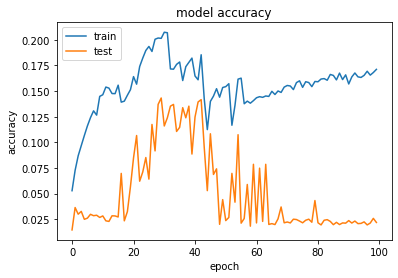

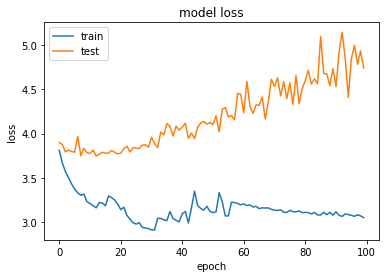

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

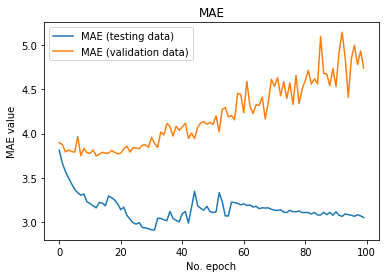

In [35]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

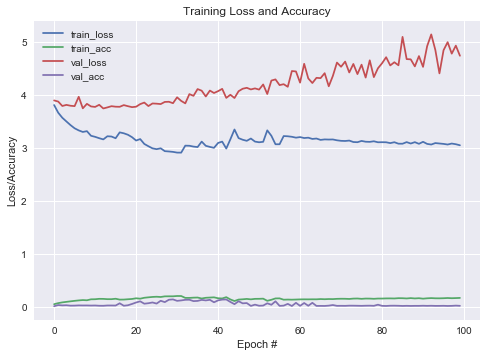

In [36]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochVGG16_OF.png')
plt.close()